# **In this notebooks we make the plots for main Fig. 2 and 3, benchmarking comparisons and analysis on simulated and real data**

In [254]:
import h5py
import scanpy as sc
import anndata
import loompy as lp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
import glob
import importlib
import seaborn as sns
import scipy

In [255]:
import sys
sys.path.insert(0, '/home/tchari/monod/src/') #OR pip install monod

In [256]:
import monod
importlib.reload(monod)
from monod import preprocess, extract_data, cme_toolbox, analysis, mminference

In [257]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

**Download data and metadata for analysis**

In [ ]:
#All result csvs
!wget --content-disposition https://github.com/pachterlab/CGP_2023/raw/main/analysis_output/all_res_csvs.tar.gz
!tar -xvf all_res_csvs.tar.gz

In [ ]:
#All meK-means results
!wget --content-disposition https://github.com/pachterlab/CGP_2023/raw/main/analysis_output/meKruns_sim_bench.tar.gz
!tar -xvf meKruns_sim_bench.tar.gz


!wget --content-disposition https://data.caltech.edu/records/fx166-d1592/files/meKruns_sim_bench_sd.tar.gz?download=1
!tar -xvf meKruns_sim_bench_sd.tar.gz

In [ ]:
#Loom files for simulation and real data
!wget --content-disposition https://data.caltech.edu/records/mzs5b-72897/files/meK_sim_looms.tar.gz?download=1
!tar -xvf meK_sim_looms.tar.gz
!wget --content-disposition https://data.caltech.edu/records/2tsha-rcz19/files/meK_looms.tar.gz?download=1
!tar -xvf meK_looms.tar.gz

In [244]:
#Saved true counts for simulations
!wget --content-disposition https://github.com/pachterlab/CGP_2023/raw/main/analysis_output/all_params.pkl

!wget --content-disposition https://github.com/pachterlab/CGP_2023/raw/main/analysis_output/all_marks.pkl

!wget --content-disposition https://github.com/pachterlab/CGP_2023/raw/main/analysis_output/negctrl_params.npy

--2024-05-28 15:12:16--  https://github.com/pachterlab/CGP_2023/raw/main/analysis_output/all_params.pkl
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pachterlab/CGP_2023/main/analysis_output/all_params.pkl [following]
--2024-05-28 15:12:16--  https://raw.githubusercontent.com/pachterlab/CGP_2023/main/analysis_output/all_params.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 696278 (680K) [application/octet-stream]
Saving to: ‘all_params.pkl’

all_params.pkl      100%[===================>] 679.96K  --.-KB/s    in 0.01s   

2024-05-28 15:12:17 (51.2 MB/s) - ‘all_params.pkl’ saved [696278/696

## **Read in all Results for Simulations and Benchmark Data**

In [102]:
# # #Save all pkls to be csvs, only need to do once, then can read in csvs

# tests = ['./fits/meKruns_0508/meK_sim_res.csv',
#         './fits/meKruns_0508/meK_bench_res.csv'] 

# for t in tests:
#     test = pd.read_csv(t)
#     print(test.head())
    
#     if 'Genes' in test.columns:
#         test['HVGs'] = test['Genes']
#     print(test.head())
#     test.to_csv(t,index=None)
#     print('Saved ',t)


In [5]:
#All clustering result files (sim and bench)
sim_res = ['./fits/LeidKMeansruns_0508/LK_sim_res.csv',
           './fits/GLUEruns_0507/GLUE_sim_res.csv',
           './fits/meKruns_0508/meK_sim_res.csv',
           './fits/scVI_sim_results.csv',
          './fits/Seuratruns_0508/WNN_sim_results.csv',
          './fits/Seuratruns_0508/MOFA_sim_results.csv']

bench_res = ['./fits/LeidKMeansruns_0508/LK_bench_res.csv',
             './fits/GLUEruns_0507/GLUE_res.csv',
            './fits/meKruns_0508/meK_bench_res.csv',
            './fits/scVI_bench_results.csv',
            './fits/Seuratruns_0508/WNN_bench_results.csv',
            './fits/scMDC_bench_results.csv',
            './fits/Seuratruns_0508/MOFA_bench_results.csv']

In [6]:
# new_test = pd.read_csv('./fits/meKruns_0508/meK_bench_res.csv')
# new_test

In [7]:
#Concatenate all csvs

li = []

for filename in sim_res:
    df = pd.read_csv(filename)
    li.append(df)

all_sims = pd.concat(li, axis=0, ignore_index=True)
all_sims.head()

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
0,Leiden,8|4|2|10|5|0|4|1|2|3|0|3|4|4|1|3|5|9|0|8|0|2|5...,U,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
1,Leiden,8|2|2|6|11|3|10|1|0|4|1|0|0|0|11|8|9|8|6|7|1|2...,S,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
2,Leiden,9|2|2|6|5|2|3|0|5|7|6|8|13|6|8|4|6|14|1|6|3|7|...,U+S,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
3,Leiden,2|6|2|0|3|2|8|9|2|5|5|2|2|5|5|1|0|0|9|2|1|2|4|...,UcatS,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
4,K-Means,5|6|4|8|10|1|3|9|10|8|6|7|1|8|2|4|8|10|9|6|4|0...,U,11.0,1100,negctrl_sim_k1,0.0,0.0,NaN


In [8]:
np.unique(all_sims.Method)

array(['GLUE-K-Means', 'GLUE-Leiden', 'K-Means', 'Leiden',
       'MOFA2-K-Means', 'MOFA2-Leiden', 'WNN-Leiden', 'meK-Means',
       'scVI-K-Means', 'scVI-Leiden'], dtype=object)

In [9]:
#Concatenate all csvs

li = []

for filename in bench_res:
    df = pd.read_csv(filename)
    li.append(df)

all_bench = pd.concat(li, axis=0, ignore_index=True)
all_bench.head()

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
0,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,U,0.75,357,cl5,0.950284,0.918657,NaN
1,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,S,0.75,357,cl5,0.986832,0.975747,NaN
2,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,U+S,0.75,357,cl5,0.965610,0.946640,NaN
3,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,UcatS,0.75,357,cl5,0.965702,0.947080,NaN
4,Leiden,3|3|1|3|3|3|4|4|3|3|1|1|3|3|3|3|3|3|3|3|1|3|3|...,U,1.00,357,cl5,0.946577,0.913621,NaN


## **ARI and AMI Plots Across Methods**

In [10]:
palette = {'U':'#FFCCCC', 'S':'#003366', 'U+S':'#8C879E', 'UcatS':'#809499', 'U,S':'#ffcc66'}

In [11]:
#Plot results stats (ARI,AMI,etc)
def stats_plots(all_sims,stat='ARI',hyp_exclude = [0.75,1.5,2.0],order = ['Leiden','K-Means'], fname=None,figsize=(4.5,7),palette=palette):

    datas = pd.unique(all_sims.Data)
    f, axes = plt.subplots(len(datas),sharey=True,sharex=True,figsize=figsize)
    for d in range(len(datas)):
        toplot = datas[d]
        sub = all_sims[all_sims.Data.isin([toplot]) & ~all_sims.Hyperparam.isin(hyp_exclude)]
        g=sns.stripplot(data=sub,x='Method',y=stat,hue='Matrices',
                        ax=axes[d],s=10,alpha=0.7,edgecolor="black",linewidth=0.75,
                       palette=palette,order=order)
        # g=sns.pointplot(data=sub,x='Method',y=stat,hue='Matrices',markersize=10, markeredgecolor='black',
        #                 markeredgewidth=0.5,
        #                 ax=axes[d],linestyle='none',alpha=0.7,
        #                palette=palette,order=order)
        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
        if d < (len(datas)-1):
            axes[d].set(xlabel=None)
            
        axes[d].set_title(toplot)  
            

    plt.xticks(rotation = 45,ha='right')
    plt.tight_layout()
    plt.ylim([-0.1,1.1])
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)




**Plot Simulations**

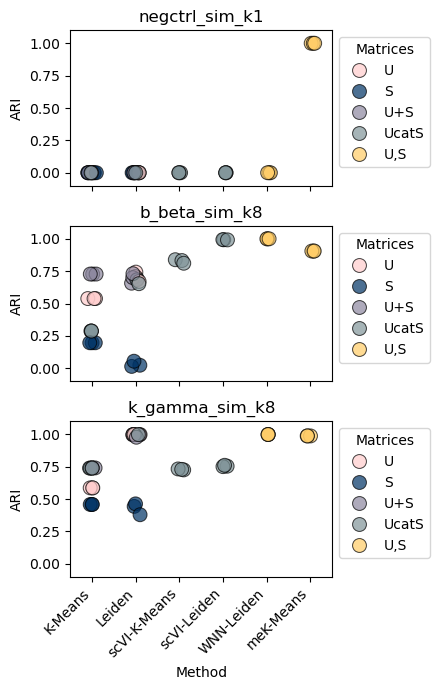

In [13]:
stats_plots(all_sims,stat='ARI',fname='ARI_main_sims_0508.pdf',
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','meK-Means'],
            figsize=(4.5,7),palette=palette) 

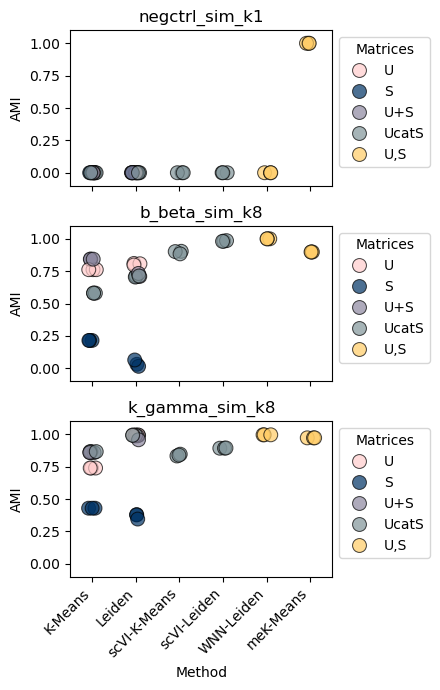

In [14]:
stats_plots(all_sims,stat='AMI',fname='AMI_main_sims_0508.pdf',
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','meK-Means'],
            figsize=(4.5,7),palette=palette) 

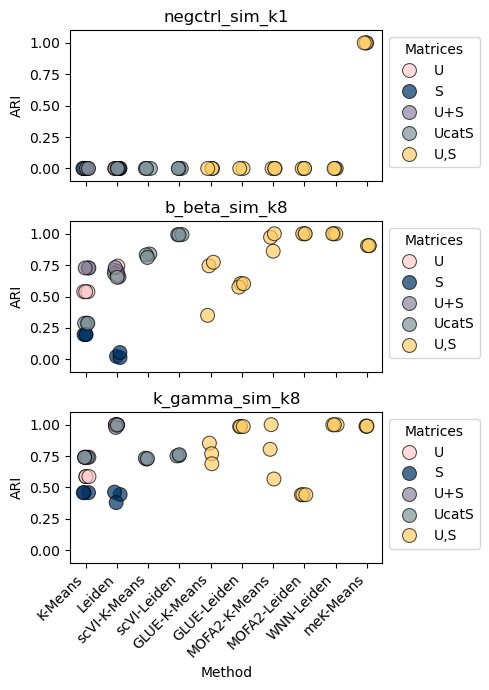

In [15]:
stats_plots(all_sims,stat='ARI',fname='ARI_all_sims_0508.pdf',
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden',
                   'GLUE-K-Means','GLUE-Leiden',
                   'MOFA2-K-Means', 'MOFA2-Leiden',
                   'WNN-Leiden','meK-Means'],
            figsize=(5,7),palette=palette) 

In [240]:
test1 = 'WNN-Leiden'
test2 = 'meK-Means'
gs = 1100
ds = 'b_beta_sim_k8'

comp1 = list(all_sims[all_sims.Data.isin([ds]) & all_sims.Method.isin([test1]) &all_sims.HVGs.isin([gs])].ARI)
comp2 = list(all_sims[all_sims.Data.isin([ds]) & all_sims.Method.isin([test2]) &all_sims.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))
#for sims data, WNN-Leiden only method that has better perofrmance than meK-means on both remaining sims (1.0 vs 0.91 K=10)
#and 1.0 vs 0.99 K=5, Thus, overall, meK-Means most consistent method on all simulations.

TtestResult(statistic=2749378070951226.0, pvalue=7.365606273639127e-195, df=13.0)
1.0
0.9053483858658039


In [242]:
test1 = 'WNN-Leiden'
test2 = 'meK-Means'
gs = 700
ds = 'k_gamma_sim_k8'

comp1 = list(all_sims[all_sims.Data.isin([ds]) & all_sims.Method.isin([test1]) &all_sims.HVGs.isin([gs]) &all_sims.Hyperparam.isin([1])].ARI)
comp2 = list(all_sims[all_sims.Data.isin([ds]) & all_sims.Method.isin([test2]) &all_sims.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))


TtestResult(statistic=139150656533410.88, pvalue=1.600332449589613e-56, df=4.0)
0.998749073083157
0.9878251032609567


In [243]:
test1 = 'GLUE-Leiden'
test2 = 'meK-Means'
gs = 700
ds = 'k_gamma_sim_k8'

comp1 = list(all_sims[all_sims.Data.isin([ds]) & all_sims.Method.isin([test1]) &all_sims.HVGs.isin([gs]) &all_sims.Hyperparam.isin([1])].ARI)
comp2 = list(all_sims[all_sims.Data.isin([ds]) & all_sims.Method.isin([test2]) &all_sims.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))


TtestResult(statistic=-37933288504265.72, pvalue=2.8978057777454784e-54, df=4.0)
0.9848471647502756
0.9878251032609567


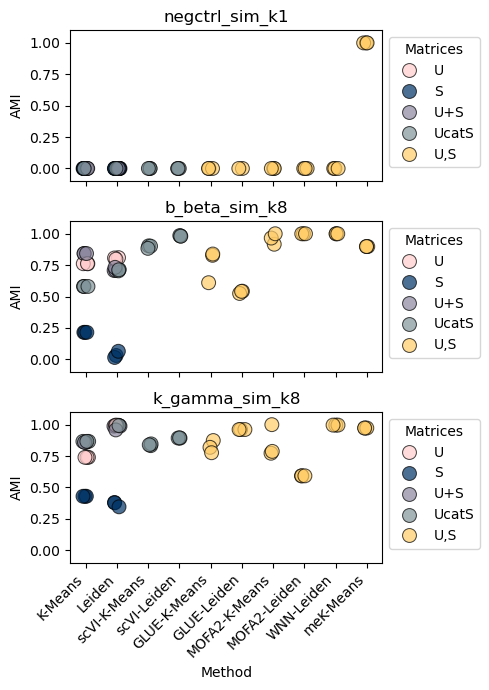

In [16]:
stats_plots(all_sims,stat='AMI',fname='AMI_all_sims_0508.pdf',
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden',
                   'GLUE-K-Means','GLUE-Leiden',
                   'MOFA2-K-Means', 'MOFA2-Leiden',
                   'WNN-Leiden','meK-Means'],
            figsize=(5,7),palette=palette) 

In [97]:
#OLD BELOW

In [98]:
# stats_plots(all_sims,stat='ARI',fname='ARI_all_sims.pdf',
#             order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','meK-Means'] ,
#             figsize=(4.5,7),palette=palette)

In [99]:
# stats_plots(all_sims,stat='AMI',fname='AMI_all_sims.pdf',
#             order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','meK-Means'] ,
#             figsize=(4.5,7),palette=palette)

**Benchmark plots**

In [202]:
all_bench[all_bench.Data.isin(['cl5']) & all_bench.Method.isin(['meK-Means']) ]

,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
528,meK-Means,4|4|2|4|4|4|3|3|4|4|2|2|4|4|4|4|4|4|4|4|2|4|4|...,"U,S",5.0,357,cl5,0.983960,0.969748,357.0
529,meK-Means,4|4|2|4|4|4|3|3|4|4|2|2|4|4|4|4|4|4|4|4|2|4|4|...,"U,S",5.0,357,cl5,0.983960,0.969748,357.0
530,meK-Means,4|4|2|4|4|4|3|3|4|4|2|2|4|4|4|4|4|4|4|4|2|4|4|...,"U,S",5.0,357,cl5,0.983960,0.969748,357.0
531,meK-Means,1|1|0|1|1|1|4|4|1|1|0|0|1|1|1|1|1|1|1|1|0|1|1|...,"U,S",5.0,1193,cl5,0.983181,0.970635,1193.0
532,meK-Means,1|1|0|1|1|1|4|4|1|1|0|0|1|1|1|1|1|1|1|1|0|1|1|...,"U,S",5.0,1193,cl5,0.983181,0.970635,1193.0
533,meK-Means,1|1|0|1|1|1|4|4|1|1|0|0|1|1|1|1|1|1|1|1|0|1|1|...,"U,S",5.0,1193,cl5,0.983181,0.970635,1193.0


In [229]:
all_bench[all_bench.Data.isin(['allen_b08']) & all_bench.Method.isin(['Leiden']) & all_bench.Matrices.isin(['UcatS']) &all_bench.Hyperparam.isin([1.0]) ]



,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
247,Leiden,3|1|7|3|0|9|2|10|1|11|0|2|4|1|1|6|7|1|1|2|5|6|...,UcatS,1.0,682,allen_b08,0.574645,0.814489,NaN
267,Leiden,3|1|7|3|0|9|2|10|1|11|0|2|4|1|1|6|7|1|1|2|5|6|...,UcatS,1.0,682,allen_b08,0.574337,0.814476,NaN
287,Leiden,4|1|7|4|0|9|2|10|1|11|0|2|3|1|1|6|7|1|1|2|5|6|...,UcatS,1.0,682,allen_b08,0.573995,0.814373,NaN
427,Leiden,4|1|7|4|0|9|2|10|1|11|0|2|3|1|1|6|7|1|1|2|5|6|...,UcatS,1.0,1948,allen_b08,0.569307,0.810417,NaN
447,Leiden,4|1|7|4|0|9|2|10|1|11|0|2|3|1|1|6|7|1|1|2|5|6|...,UcatS,1.0,1948,allen_b08,0.569859,0.810059,NaN
467,Leiden,4|1|7|4|0|9|3|10|1|11|0|3|2|1|1|6|7|1|1|3|5|6|...,UcatS,1.0,1948,allen_b08,0.567632,0.807581,NaN


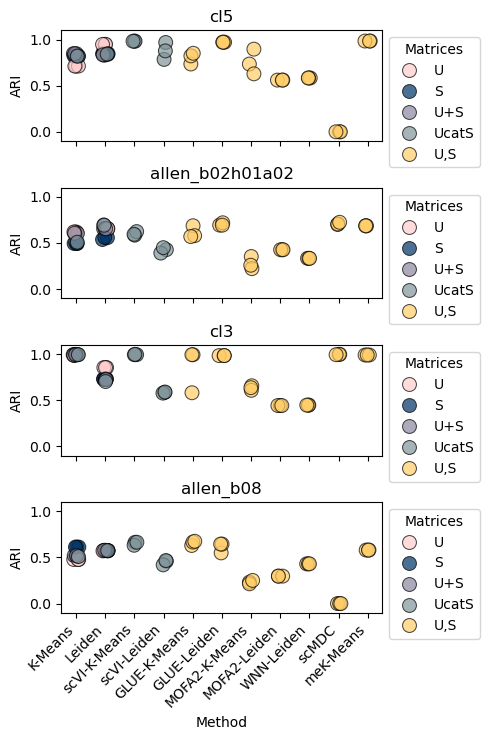

In [114]:
sub_all_bench = all_bench[all_bench.HVGs.isin([357,  359,  466,  682])]
stats_plots(sub_all_bench,stat='ARI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden',
                   'GLUE-K-Means','GLUE-Leiden',
                   'MOFA2-K-Means', 'MOFA2-Leiden',
                   'WNN-Leiden','scMDC','meK-Means'],
            fname='ARI_all_bench_0508.pdf',figsize=(5,7.5))

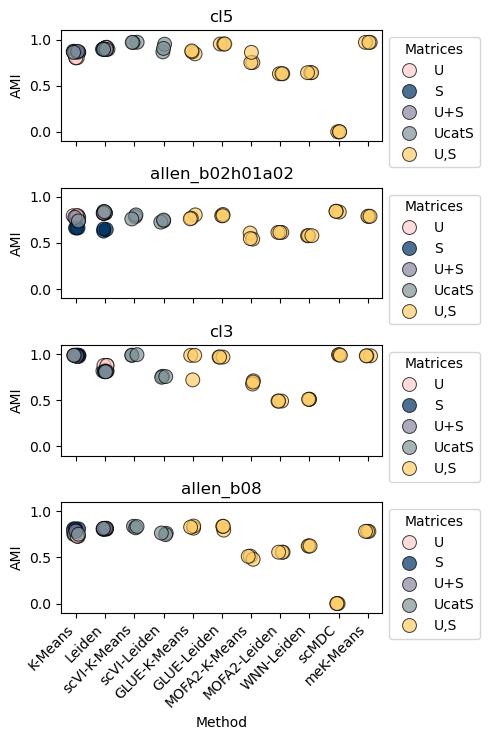

In [115]:
sub_all_bench = all_bench[all_bench.HVGs.isin([357,  359,  466,  682])]
stats_plots(sub_all_bench,stat='AMI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden',
                   'GLUE-K-Means','GLUE-Leiden',
                   'MOFA2-K-Means', 'MOFA2-Leiden',
                   'WNN-Leiden','scMDC','meK-Means'],
            fname='AMI_all_bench_0508.pdf',figsize=(5,7.5))

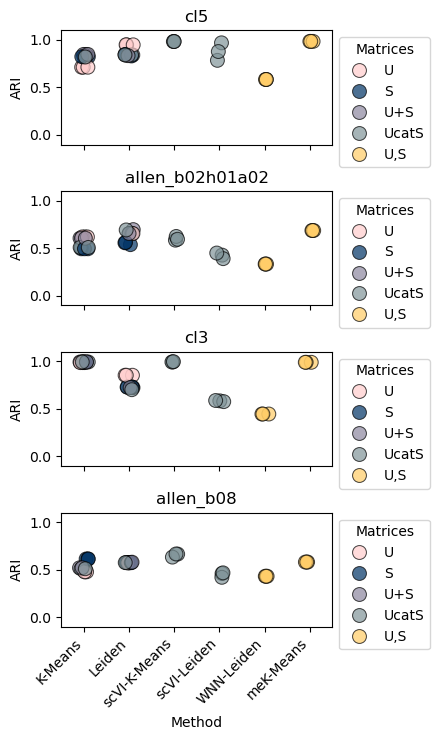

In [116]:
sub_all_bench = all_bench[all_bench.HVGs.isin([357,  359,  466,  682])]
stats_plots(sub_all_bench,stat='ARI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden',
                   'WNN-Leiden','meK-Means'],
            fname='ARI_main_bench_0508.pdf',figsize=(4.5,7.5))

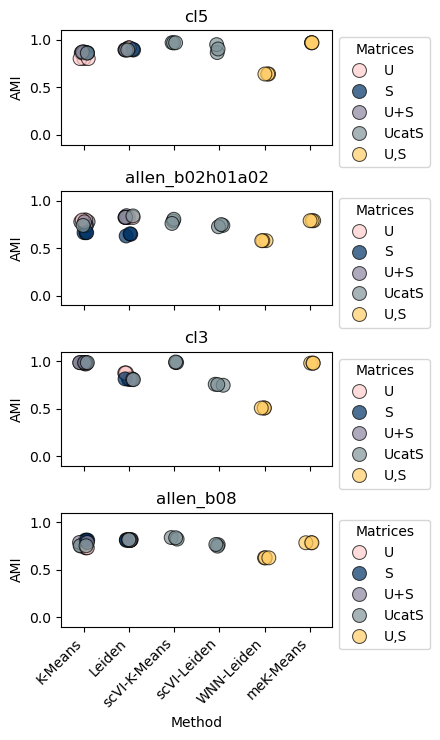

In [117]:
sub_all_bench = all_bench[all_bench.HVGs.isin([357,  359,  466,  682])]
stats_plots(sub_all_bench,stat='AMI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden',
                   'WNN-Leiden','meK-Means'],
            fname='AMI_main_bench_0508.pdf',figsize=(4.5,7.5))

Run statistical comparisons

In [208]:
test1 = 'scVI-K-Means'
test2 = 'meK-Means'
gs = 357
ds = 'cl5'

comp1 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test1]) &all_bench.HVGs.isin([gs])].ARI)
comp2 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test2]) &all_bench.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))
#For cl5, scVI-K-Means and meK-Means equivalent top performance (avg 0.98) significantly better ARI than next best, GLUE-Leiden (p-value <0.05)
#For cl3 

TtestResult(statistic=-4.142665766338061, pvalue=0.014345423907500852, df=4.0)
0.9825598426888718
0.9839601052752456


/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [209]:
test1 = 'GLUE-Leiden'
test2 = 'meK-Means'
gs = 357
ds = 'cl5'

comp1 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test1]) &all_bench.HVGs.isin([gs])].ARI)
comp2 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test2]) &all_bench.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))


TtestResult(statistic=-inf, pvalue=0.0, df=4.0)
0.9712899473574214
0.9839601052752456


In [218]:
test1 = 'scMDC'
test2 = 'scVI-K-Means'
gs = 466
ds = 'cl3'

comp1 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test1]) &all_bench.HVGs.isin([gs])].ARI)
comp2 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test2]) &all_bench.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))
#For cl3, scMDC and scVI-K-Means equivalent best with avgs ~0.995,followed by meK-Means at 0.990, and signifcantly better than all other methods.
#meK-Means sig better than GLUE-Leiden

TtestResult(statistic=0.7017158266817365, pvalue=0.5215368286448901, df=4.0)
0.995521952967533
0.9943746115554096


In [219]:
test1 = 'GLUE-Leiden'
test2 = 'meK-Means'
gs = 466
ds = 'cl3'

comp1 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test1]) &all_bench.HVGs.isin([gs])].ARI)
comp2 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test2]) &all_bench.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))


TtestResult(statistic=-inf, pvalue=0.0, df=4.0)
0.9835645337762752
0.9898199303468976


In [222]:
test1 = 'GLUE-Leiden'
test2 = 'meK-Means'
gs = 359
ds = 'allen_b02h01a02'

comp1 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test1]) &all_bench.HVGs.isin([gs])].ARI)
comp2 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test2]) &all_bench.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1)) #GLUE is more variable here
print(np.mean(comp2))

TtestResult(statistic=1.8561130917272763, pvalue=0.13701574114109033, df=4.0)
0.7013616844419772
0.6856325470667358


In [228]:
test1 = 'scMDC'
test2 = 'meK-Means'
gs = 359
ds = 'allen_b02h01a02'

comp1 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test1]) &all_bench.HVGs.isin([gs])].ARI)
comp2 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test2]) &all_bench.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))
#For MOp_sn, only method sign diff/higher than meK-Means is scMDC (avg 0.71) with meK-Means with avg of 0.69 

TtestResult(statistic=3.359313649171156, pvalue=0.02832287149660089, df=4.0)
0.7096904952586164
0.6856325470667358


In [234]:
test1 = 'scVI-K-Means'
test2 = 'meK-Means'
gs = 682
ds = 'allen_b08'

comp1 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test1]) &all_bench.HVGs.isin([gs])].ARI)
comp2 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test2]) &all_bench.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))

#For MOp_sc GLUE- and scVI-K-Means signifcantly higher than other methods (~0.65), followed by meK-Means (0.58), 
#and meK-Means results not variable over rounds


TtestResult(statistic=6.836323191515323, pvalue=0.0023950625916240816, df=4.0)
0.6534203637668039
0.5798177849988733


In [238]:
test1 = 'GLUE-K-Means'
test2 = 'meK-Means'
gs = 682
ds = 'allen_b08'

comp1 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test1]) &all_bench.HVGs.isin([gs])].ARI)
comp2 = list(all_bench[all_bench.Data.isin([ds]) & all_bench.Method.isin([test2]) &all_bench.HVGs.isin([gs]) ].ARI)
print(scipy.stats.ttest_ind(comp1,comp2))

print(np.mean(comp1))
print(np.mean(comp2))


TtestResult(statistic=1.0383156395585733, pvalue=0.35776457271462064, df=4.0)
0.6128194168146229
0.5798177849988733


In [ ]:
#So meK-Means consistently demonstrated signifcantly better performance versus the majority of other methods tested
#And no other method that was consistently the top performer...

Large no. of genes plots

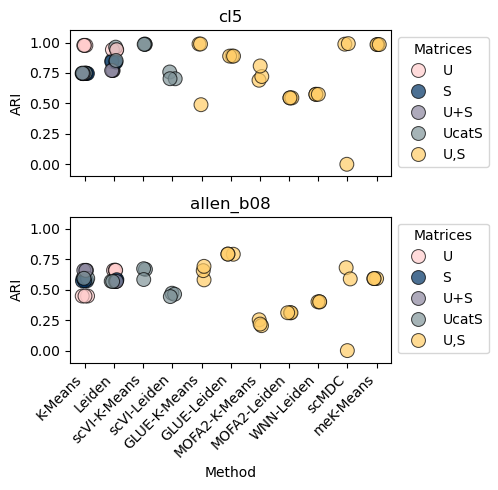

In [118]:
#Use cl3 + allen_bo8 since scMDC worked for both
sub_all_bench = all_bench[~all_bench.HVGs.isin([357,  359,  466,  682]) * all_bench.Data.isin(['cl5','allen_b08'])]
stats_plots(sub_all_bench,stat='ARI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden',
                   'GLUE-K-Means','GLUE-Leiden',
                   'MOFA2-K-Means', 'MOFA2-Leiden',
                   'WNN-Leiden','scMDC','meK-Means'],
            fname='ARI_all_bench_lgHVGs_0508.pdf',figsize=(5,5))

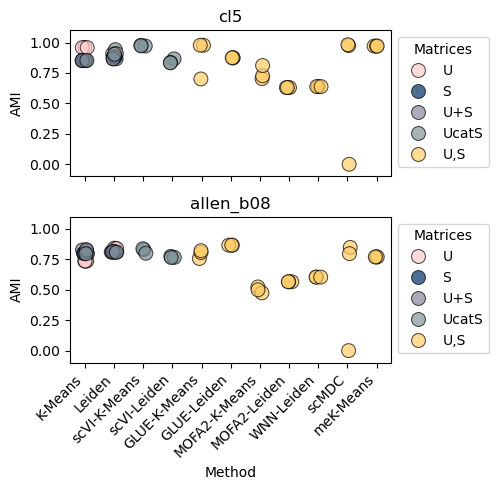

In [119]:
#Use cl3 + allen_bo8 since scMDC worked for both
sub_all_bench = all_bench[~all_bench.HVGs.isin([357,  359,  466,  682]) * all_bench.Data.isin(['cl5','allen_b08'])]
stats_plots(sub_all_bench,stat='AMI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
            order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden',
                   'GLUE-K-Means','GLUE-Leiden',
                   'MOFA2-K-Means', 'MOFA2-Leiden',
                   'WNN-Leiden','scMDC','meK-Means'],
            fname='AMI_all_bench_lgHVGs_0508.pdf',figsize=(5,5))

In [75]:
# stats_plots(sub_all_bench,stat='AMI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
#             order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','scMDC','meK-Means'],
#             fname='AMI_all_bench_lgHVGs.pdf',figsize=(4.5,7.5))

In [74]:
# #**PUT ASTERISK BY scMDC, because it didn't run hence the 0..**
# sub_all_bench = all_bench[all_bench.HVGs.isin([357,  359,  466,  682]) & ~(all_bench.Method.isin(['meK-Means','scMDC']) & all_bench.Hyperparam.isin([10]) & all_bench.Data.isin(['cl5']))]
# stats_plots(sub_all_bench,stat='ARI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
#             order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','scMDC','meK-Means'],
#             fname='ARI_all_bench.pdf',figsize=(4.5,7.5))

In [73]:
# stats_plots(sub_all_bench,stat='AMI',hyp_exclude = [-1,0.75,1.5,2.0,8,15,16],
#             order=['K-Means','Leiden','scVI-K-Means','scVI-Leiden','WNN-Leiden','scMDC','meK-Means'],
#             fname='AMI_all_bench.pdf',figsize=(4.5,7.5))

Plot pairwise overlaps of clusterings for Negative Ctrl sim and allen_b08

In [122]:
import itertools

In [121]:
#Get all results frm negctrl to compare
pair_all_sims = all_sims[~all_sims.Hyperparam.isin([0.75,1.5,2.0]) & all_sims.Data.isin(['negctrl_sim_k1'])]
pair_all_sims


,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
0,Leiden,8|4|2|10|5|0|4|1|2|3|0|3|4|4|1|3|5|9|0|8|0|2|5...,U,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
1,Leiden,8|2|2|6|11|3|10|1|0|4|1|0|0|0|11|8|9|8|6|7|1|2...,S,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
2,Leiden,9|2|2|6|5|2|3|0|5|7|6|8|13|6|8|4|6|14|1|6|3|7|...,U+S,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
3,Leiden,2|6|2|0|3|2|8|9|2|5|5|2|2|5|5|1|0|0|9|2|1|2|4|...,UcatS,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
4,K-Means,5|6|4|8|10|1|3|9|10|8|6|7|1|8|2|4|8|10|9|6|4|0...,U,11.0,1100,negctrl_sim_k1,0.0,0.0,NaN
5,K-Means,4|2|4|9|10|5|2|8|6|1|5|4|5|2|6|9|2|9|10|3|7|7|...,S,11.0,1100,negctrl_sim_k1,0.0,0.0,NaN
6,K-Means,9|8|8|9|4|9|1|6|1|5|3|5|1|8|6|3|8|1|6|9|4|8|1|...,U+S,11.0,1100,negctrl_sim_k1,0.0,0.0,NaN
7,K-Means,4|9|6|4|10|1|10|5|1|10|3|5|1|4|6|6|9|1|8|4|6|6...,UcatS,11.0,1100,negctrl_sim_k1,0.0,0.0,NaN
8,Leiden,3|3|7|3|1|2|1|5|4|0|8|9|2|1|0|7|9|4|6|6|9|3|11...,U,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN
9,Leiden,7|0|8|2|4|4|5|1|0|3|0|1|3|4|3|4|2|9|8|3|0|1|4|...,S,1.0,1100,negctrl_sim_k1,0.0,0.0,NaN


In [124]:
all_individs = [pair_all_sims.iloc[i]['Method']+'_'+pair_all_sims.iloc[i]['Matrices'] for i in range(len(pair_all_sims))]
all_pos = range(len(pair_all_sims))
all_individs

['Leiden_U',
 'Leiden_S',
 'Leiden_U+S',
 'Leiden_UcatS',
 'K-Means_U',
 'K-Means_S',
 'K-Means_U+S',
 'K-Means_UcatS',
 'Leiden_U',
 'Leiden_S',
 'Leiden_U+S',
 'Leiden_UcatS',
 'K-Means_U',
 'K-Means_S',
 'K-Means_U+S',
 'K-Means_UcatS',
 'Leiden_U',
 'Leiden_S',
 'Leiden_U+S',
 'Leiden_UcatS',
 'K-Means_U',
 'K-Means_S',
 'K-Means_U+S',
 'K-Means_UcatS',
 'GLUE-K-Means_U,S',
 'GLUE-Leiden_U,S',
 'GLUE-K-Means_U,S',
 'GLUE-Leiden_U,S',
 'GLUE-K-Means_U,S',
 'meK-Means_U,S',
 'meK-Means_U,S',
 'meK-Means_U,S',
 'scVI-Leiden_UcatS',
 'scVI-K-Means_UcatS',
 'scVI-Leiden_UcatS',
 'scVI-K-Means_UcatS',
 'scVI-Leiden_UcatS',
 'scVI-K-Means_UcatS',
 'WNN-Leiden_U,S',
 'WNN-Leiden_U,S',
 'WNN-Leiden_U,S',
 'MOFA2-Leiden_U,S',
 'MOFA2-K-Means_U,S',
 'MOFA2-Leiden_U,S',
 'MOFA2-K-Means_U,S',
 'MOFA2-Leiden_U,S',
 'MOFA2-K-Means_U,S']

In [127]:
individs = np.unique(all_individs)
pos = [all_pos[all_individs.index(i)] for i in individs]
individs

array(['GLUE-K-Means_U,S', 'GLUE-Leiden_U,S', 'K-Means_S', 'K-Means_U',
       'K-Means_U+S', 'K-Means_UcatS', 'Leiden_S', 'Leiden_U',
       'Leiden_U+S', 'Leiden_UcatS', 'MOFA2-K-Means_U,S',
       'MOFA2-Leiden_U,S', 'WNN-Leiden_U,S', 'meK-Means_U,S',
       'scVI-K-Means_UcatS', 'scVI-Leiden_UcatS'], dtype='<U18')

In [133]:
conv_pos = dict(zip(pos,range(len(pos))))
conv_pos

{24: 0,
 25: 1,
 5: 2,
 4: 3,
 6: 4,
 7: 5,
 1: 6,
 0: 7,
 2: 8,
 3: 9,
 42: 10,
 41: 11,
 38: 12,
 29: 13,
 33: 14,
 32: 15}

In [134]:
pairs = list(itertools.combinations(pos, 2))
aris_pairs_sims = np.zeros([len(pos),len(pos)]) 
for p in pairs:
    out = adjusted_rand_score(pair_all_sims.iloc[p[0]]['Clustering'].split('|'),pair_all_sims.iloc[p[1]]['Clustering'].split('|'))
    aris_pairs_sims[conv_pos[p[0]],conv_pos[p[1]]] = out
    aris_pairs_sims[conv_pos[p[1]],conv_pos[p[0]]] = out

aris_pairs_sims = aris_pairs_sims + np.eye(len(pos),len(pos)) 


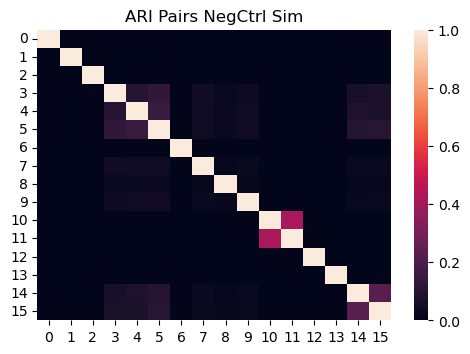

In [135]:
plt.figure(figsize=(5,3.5))
sns.heatmap(aris_pairs_sims, annot = False,vmin=0, vmax=1.0)
plt.tight_layout()
plt.title('ARI Pairs NegCtrl Sim')
plt.savefig('ARI_pairs_negctrl_sim.pdf')

In [140]:
#Get all results frm allen_b08 to compare #DO SINGLE_NUC
sub_all_bench = all_bench[all_bench.HVGs.isin([357,  359,  466,  682]) * all_bench.Data.isin(['allen_b02h01a02'])]
pair_all_bench = sub_all_bench[~sub_all_bench.Hyperparam.isin([-1,0.75,1.5,2.0,8,15,16])]
pair_all_bench


,Method,Clustering,Matrices,Hyperparam,HVGs,Data,ARI,AMI,Genes
124,Leiden,10|1|1|5|2|3|8|1|2|5|3|0|0|2|1|1|2|1|1|1|0|2|8...,U,1.0,359,allen_b02h01a02,0.653893,0.822319,NaN
125,Leiden,3|0|0|4|3|1|5|0|0|4|1|2|1|3|0|0|3|0|0|0|2|3|5|...,S,1.0,359,allen_b02h01a02,0.536883,0.628177,NaN
126,Leiden,10|1|1|5|3|2|7|1|3|5|2|0|0|3|1|1|3|1|1|1|0|3|7...,U+S,1.0,359,allen_b02h01a02,0.695059,0.841492,NaN
127,Leiden,10|1|1|5|2|3|8|1|2|5|3|0|0|2|1|1|2|1|1|1|0|2|8...,UcatS,1.0,359,allen_b02h01a02,0.653187,0.823515,NaN
136,K-Means,6|0|0|3|8|10|2|0|8|3|10|10|10|8|0|0|8|0|0|0|4|...,U,11.0,359,allen_b02h01a02,0.618152,0.794970,NaN
137,K-Means,2|6|7|8|4|5|10|7|4|8|5|1|5|4|0|6|4|0|7|7|1|4|1...,S,11.0,359,allen_b02h01a02,0.493636,0.662815,NaN
138,K-Means,6|7|7|6|9|9|8|7|9|6|1|1|1|10|7|7|10|7|7|7|2|9|...,U+S,11.0,359,allen_b02h01a02,0.604605,0.777492,NaN
139,K-Means,10|0|0|2|9|1|8|0|9|2|1|4|4|9|0|0|9|0|0|0|3|9|8...,UcatS,11.0,359,allen_b02h01a02,0.507502,0.738747,NaN
144,Leiden,10|1|1|5|2|3|8|1|2|5|3|0|0|2|1|1|2|1|1|1|0|2|8...,U,1.0,359,allen_b02h01a02,0.654291,0.822433,NaN
145,Leiden,3|0|0|3|4|1|5|0|0|3|1|2|1|4|0|0|4|0|0|0|2|4|5|...,S,1.0,359,allen_b02h01a02,0.556798,0.645715,NaN


In [142]:
all_individs = [pair_all_bench.iloc[i]['Method']+'_'+pair_all_bench.iloc[i]['Matrices'] for i in range(len(pair_all_bench))]
all_pos = range(len(pair_all_bench))
all_individs

['Leiden_U',
 'Leiden_S',
 'Leiden_U+S',
 'Leiden_UcatS',
 'K-Means_U',
 'K-Means_S',
 'K-Means_U+S',
 'K-Means_UcatS',
 'Leiden_U',
 'Leiden_S',
 'Leiden_U+S',
 'Leiden_UcatS',
 'K-Means_U',
 'K-Means_S',
 'K-Means_U+S',
 'K-Means_UcatS',
 'Leiden_U',
 'Leiden_S',
 'Leiden_U+S',
 'Leiden_UcatS',
 'K-Means_U',
 'K-Means_S',
 'K-Means_U+S',
 'K-Means_UcatS',
 'GLUE-Leiden_U,S',
 'GLUE-K-Means_U,S',
 'GLUE-Leiden_U,S',
 'GLUE-K-Means_U,S',
 'GLUE-Leiden_U,S',
 'GLUE-K-Means_U,S',
 'meK-Means_U,S',
 'meK-Means_U,S',
 'meK-Means_U,S',
 'scVI-Leiden_UcatS',
 'scVI-K-Means_UcatS',
 'scVI-Leiden_UcatS',
 'scVI-K-Means_UcatS',
 'scVI-Leiden_UcatS',
 'scVI-K-Means_UcatS',
 'WNN-Leiden_U,S',
 'WNN-Leiden_U,S',
 'WNN-Leiden_U,S',
 'scMDC_U,S',
 'scMDC_U,S',
 'scMDC_U,S',
 'MOFA2-Leiden_U,S',
 'MOFA2-K-Means_U,S',
 'MOFA2-Leiden_U,S',
 'MOFA2-K-Means_U,S',
 'MOFA2-Leiden_U,S',
 'MOFA2-K-Means_U,S']

In [144]:
# individs = [pair_all_bench.iloc[i]['Method']+'_'+pair_all_bench.iloc[i]['Matrices'] for i in range(len(pair_all_bench))]
# pos = range(len(pair_all_bench))
# individs

individs = np.unique(all_individs)
pos = [all_pos[all_individs.index(i)] for i in individs]
individs

array(['GLUE-K-Means_U,S', 'GLUE-Leiden_U,S', 'K-Means_S', 'K-Means_U',
       'K-Means_U+S', 'K-Means_UcatS', 'Leiden_S', 'Leiden_U',
       'Leiden_U+S', 'Leiden_UcatS', 'MOFA2-K-Means_U,S',
       'MOFA2-Leiden_U,S', 'WNN-Leiden_U,S', 'meK-Means_U,S', 'scMDC_U,S',
       'scVI-K-Means_UcatS', 'scVI-Leiden_UcatS'], dtype='<U18')

In [145]:
conv_pos = dict(zip(pos,range(len(pos))))
conv_pos

{25: 0,
 24: 1,
 5: 2,
 4: 3,
 6: 4,
 7: 5,
 1: 6,
 0: 7,
 2: 8,
 3: 9,
 46: 10,
 45: 11,
 39: 12,
 30: 13,
 42: 14,
 34: 15,
 33: 16}

In [146]:
pairs = list(itertools.combinations(pos, 2))
aris_pairs_bench = np.zeros([len(pos),len(pos)]) 
for p in pairs:
    out = adjusted_rand_score(pair_all_bench.iloc[p[0]]['Clustering'].split('|'),pair_all_bench.iloc[p[1]]['Clustering'].split('|'))
    aris_pairs_bench[conv_pos[p[0]],conv_pos[p[1]]] = out
    aris_pairs_bench[conv_pos[p[1]],conv_pos[p[0]]] = out

aris_pairs_bench = aris_pairs_bench + np.eye(len(pos),len(pos)) 


In [500]:
# pairs = list(itertools.combinations(pos, 2))
# aris_pairs_bench = np.zeros([len(pos),len(pos)]) 
# for p in pairs:
#     out = adjusted_rand_score(pair_all_bench.iloc[p[0]]['Clustering'].split('|'),pair_all_bench.iloc[p[1]]['Clustering'].split('|'))
#     aris_pairs_bench[p[0],p[1]] = out
#     aris_pairs_bench[p[1],p[0]] = out

# aris_pairs_bench = aris_pairs_bench + np.eye(len(pos),len(pos)) 


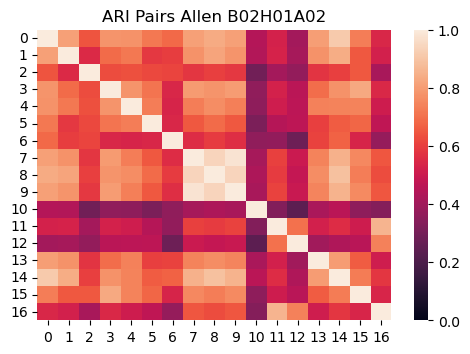

In [147]:
plt.figure(figsize=(5,3.5))
sns.heatmap(aris_pairs_bench, annot = False,vmin=0, vmax=1.0)
plt.tight_layout()
plt.title('ARI Pairs Allen B02H01A02')
plt.savefig('ARI_pairs_allenb02h01a02_bench.pdf')

## **meK-Means Parameter Recapitulation Plots**

Read in results for all simulations and all benchmark datasets with the relevant K

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
col_all_par = '#4472C4'
col_b = '#1B9AAA'
col_beta = '#9fcbee'
col_gamma ='#3C50B1'
col_expr = '#9299A0'


In [20]:
def check_at_bounds(phys_params,thr=0.01,phys_lb=[-2.0, -1.8, -1.8 ],phys_ub=[4.2, 2.5, 2.5]):
    #Check for genes where parameter fits are close to boundary of grid
    x = np.any(np.logical_or(
        np.array(phys_lb)+thr > phys_params,
        np.array(phys_ub)-thr < phys_params) ,1)
    return x

In [21]:
def plot_conf_mat(true,assign,title='',figsize=(18, 5),fname=None):
    
    #If true labels string, make them ints for plotting  
    if (type(true[0]) != int):
        d = dict(zip(np.unique(true),list(range(len(np.unique(true))))))
        print('Annotations converted to: ',d)
        
        true = [d[t] for t in true]
        true_copy = true.copy()
    else:   
        true_copy = list(true)
    assign_copy = list(assign)
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                true_copy += [a]
                assign_copy += [a]
    true_copy = np.array(true_copy)
    assign_copy = np.array(assign_copy)
    
    conmat = confusion_matrix(true_copy, assign_copy)
    val = np.mat(conmat) 
    classnames = list(set(true_copy))
    df_cm = pd.DataFrame(

            val, index=classnames, columns=classnames, 

        )
    
    if np.max(assign) > np.max(true): 
        for a in np.unique(assign):
            if a > np.max(true):
                print(df_cm.shape)
                df_cm.loc[a,a] = df_cm.loc[a,a]-1
         
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    #Plot confusion matrix
    heatmap = sns.heatmap(df_cm, annot=False, fmt=".0f",cmap=sns.color_palette("light:#5A9", as_cmap=True),
                          ax=ax,square=True,linewidths=0.5, cbar_kws={"shrink": 1})
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',
                                 fontsize=14)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0,
                                fontsize=14)
    
    heatmap.axhline(y=0, color='k',linewidth=2)
    heatmap.axhline(y=val.shape[1], color='k',linewidth=2)
    heatmap.axvline(x=0, color='k',linewidth=2)
    heatmap.axvline(x=val.shape[0], color='k',linewidth=2)

    ax.set_ylabel('True State',fontsize=18)
    ax.set_xlabel('Assigned State',fontsize=18)
    ax.set_title(title)
    
    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)

In [22]:
#Plot correlation of inferred means to observed means
def plot_means(sd,sr,clus=0,title='',figsize=(18,18),fname=None):
    
    clus_ind = [i for i in range(len(sr)) if clus == sr[i].assigns][0]
 
    which_sr = sr[clus_ind]
    mm = which_sr.param_estimates[0,:,:] #genes x params
    
    filt = ~check_at_bounds(mm,thr=0.01) #Filter out genes with bad fits
    
    samp_ub = which_sr.find_sampling_optimum()
    
    mm_u = (mm[:,0]+(samp_ub[0]+sd.gene_log_lengths))-mm[:,1]
    mm_s = (mm[:,0]+samp_ub[1])-mm[:,2]
    #print(mm_s.shape)
    
    
    true_s = sd.layers[1,:,which_sr.filt] #cell x gene
    true_u = sd.layers[0,:,which_sr.filt]
    mean_s = np.mean(true_s,axis=0)
    mean_u = np.mean(true_u,axis=0)
    #print(mean_u.shape)


    
    rho =[]
    p = []   
    
    #Plot param mean correlations
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    
    g=sns.scatterplot(y=list(mean_u[filt & (mean_u!=0)]),x=list(10**mm_u[filt & (mean_u!=0)]),
                    s=70,edgecolor='black',color='#FFCCCC', alpha=0.8,ax=ax[0])
    ax[0].tick_params(axis='both', which='major', labelsize=14,)
   
    
    rho += [np.corrcoef(list(np.log(mean_u[filt & (mean_u!=0)])),list(np.log(10**mm_u[filt & (mean_u!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_u[filt & (mean_u!=0)]),list(10**mm_u[filt & (mean_u!=0)]))[0]]
    
    ax[0].set_xlabel('meK-Means '+r'$\mu_U$',fontsize=14)
    ax[0].set_ylabel('Obs '+r'$\mu_U$',fontsize=14)
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')
    ax[0].set_title(title)

    
    
    g2=sns.scatterplot(y=list(mean_s[filt & (mean_s!=0)]),x=list(10**mm_s[filt & (mean_s!=0)]),
                    s=70,edgecolor='black',color='#003366', alpha=0.6,ax=ax[1])
    ax[1].tick_params(axis='both', which='major', labelsize=14,)
   
    
    rho += [np.corrcoef(list(np.log(mean_s[filt & (mean_s!=0)])),list(np.log(10**mm_s[filt & (mean_s!=0)])))[0,1]]
    p += [scipy.stats.spearmanr(list(mean_s[filt & (mean_s!=0)]),list(10**mm_s[filt & (mean_s!=0)]))[0]]
    
    ax[1].set_xlabel('meK-Means '+r'$\mu_S$',fontsize=14)
    ax[1].set_ylabel('Obs '+r'$\mu_S$',fontsize=14)
    ax[1].set_xscale('log')
    ax[1].set_yscale('log')
    
    for i, a in enumerate(ax.flat):

       
        bot,top = a.get_ylim()
        l,r = a.get_xlim()

        newl = np.min([bot,l])
        newr = np.max([top,r])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i]),fontsize=14,transform=a.transAxes)
        a.text(.05,.85,r'$\rho$ = {:.2f}'.format(p[i]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)

        
    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)

    
    

In [23]:
#Plot parameter distributions vs true params only
def plot_true_params(all_params,sr,true_clus=0,fit_clus=0,figsize=(18,18),fname=None):
    
    b_sim_true = all_params[true_clus,:,:] #kxgenex6 -->0,2,3 b,beta,gamma
    
    clus_ind = [i for i in range(len(sr)) if fit_clus == sr[i].assigns][0]
    which_sr = sr[clus_ind]
    b_sim_mm = which_sr.param_estimates[0,:,:]
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    
    rho =[]
    p = []   
    
    

    comps = pd.DataFrame()
    comps['b'] = list(b_sim_true[filt,0])+list(b_sim_mm[filt,0])
    comps['beta'] = list(b_sim_true[filt,2])+list(b_sim_mm[filt,1])
    comps['gamma'] = list(b_sim_true[filt,3])+list(b_sim_mm[filt,2])
    comps['setting'] = ['True']*np.sum(filt) + ['meK-Means']*np.sum(filt)


    #Plot param histograms
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=figsize)


    #Plot correlations
    comps_true = comps[comps.setting.isin(['True'])]
    comps_mm = comps[comps.setting.isin(['meK-Means'])]


    #mm v true
    g=sns.scatterplot(x=list(comps_mm['b']),y=list(comps_true['b']),
                    s=50,edgecolor='black',color=col_b, alpha=0.7,ax=ax[0])
    #ax[3,0].text(x=-1, y=2, s=np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1])
    rho += [np.corrcoef(list(comps_mm['b']),list(comps_true['b']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['b']),list(comps_true['b']))[0]]
   

    g1=sns.scatterplot(x=list(comps_mm['beta']),y=list(comps_true['beta']),
                    s=50,edgecolor='black',color=col_beta, alpha=0.7,ax=ax[1],legend=False)
    #ax[3,1].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1])
    rho += [np.corrcoef(list(comps_mm['beta']),list(comps_true['beta']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['beta']),list(comps_true['beta']))[0]]
    


    g2=sns.scatterplot(x=list(comps_mm['gamma']),y=list(comps_true['gamma']),
                    s=50,edgecolor='black',color=col_gamma, alpha=0.7,ax=ax[2],legend=False)
    #ax[3,2].text(x=-1, y=0.5, s=np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1])
    rho += [np.corrcoef(list(comps_mm['gamma']),list(comps_true['gamma']))[0,1]]
    p += [scipy.stats.spearmanr(list(comps_mm['gamma']),list(comps_true['gamma']))[0]]

    
    ax[0].set_xlabel('meK-Means')
    ax[0].set_ylabel('True')
    
    
    for i, a in enumerate(ax.flat):


        bot,top = a.get_ylim()
        l,r = a.get_xlim()

        newl = np.min([bot,l])
        newr = np.max([top,r])

        a.set_xlim((newl,newr))
        a.set_ylim((newl,newr))

        a.text(.05,.7,r'$r$ = {:.2f}'.format(rho[i-3]),fontsize=14,transform=a.transAxes)
        a.text(.05,.8,r'$\rho$ = {:.2f}'.format(p[i-3]),fontsize=14,transform=a.transAxes)

        a.plot(a.get_xlim(),a.get_xlim(),'--',color=[116/255,112/255,113/255],linewidth=3,alpha=0.4)



    
    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)

In [24]:
#Simulation data function
def plot_3d_markers(sr,all_marks,true_clus=0,fit_clus=0,mark_color = '#73a580',figsize=(18,18),fname=None):
    
    marks = all_marks[true_clus*100:(true_clus*100+100)]
    
    clus_ind = [i for i in range(len(sr)) if fit_clus == sr[i].assigns][0]
    which_sr = sr[clus_ind]
    b_sim_mm = which_sr.param_estimates[0,:,:]
    
    sim_mm_cat = []
    for remain in range(len(sr)):
        if sr[remain].assigns != fit_clus:
            sim_mm_cat += [sr[remain].param_estimates[0,:,:]]
    
    sim_mm_cat = np.array(sim_mm_cat)
    #print(np.array(sim_mm_cat)[:,[0,1,2],0].flatten().shape)
    
    allinds = np.array(range(which_sr.n_genes))
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    

    toplot = [i for i in marks if i in list(allinds[filt])]
    
    
    all_b_beta = pd.DataFrame()
    all_b_beta['b'] = list(b_sim_mm[toplot,0]) + list(sim_mm_cat[:,toplot,0].flatten())
    all_b_beta['beta'] = list(b_sim_mm[toplot,1]) + list(sim_mm_cat[:,toplot,1].flatten())
    all_b_beta['gamma'] = list(b_sim_mm[toplot,2]) + list(sim_mm_cat[:,toplot,2].flatten())
    all_b_beta['state'] = ['Marked State']*len(toplot) + ['Other States']*len(toplot)*(len(sr)-1)


    palette={'Marked State':mark_color,'Other States':'grey'}
    
    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(projection='3d')

    all_colors = [palette[i] for i in all_b_beta['state']]
    ax.scatter(all_b_beta['b'], all_b_beta['beta'], all_b_beta['gamma'],
               c=all_colors,s=80,alpha=0.5, edgecolor='black',linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=14,pad=-3)


    ax.grid(None)
    
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)
    

In [25]:
#Simulation data function
def plot_joint_markers(sr,all_marks,true_clus=0,fit_clus=0,mark_color = '#73a580',figsize=(18,18),fname=None):
    #Jointplot of markers
    
    marks = all_marks[true_clus*100:(true_clus*100+100)]
    
    clus_ind = [i for i in range(len(sr)) if fit_clus == sr[i].assigns][0]
    which_sr = sr[clus_ind]
    b_sim_mm = which_sr.param_estimates[0,:,:]
    
    sim_mm_cat = []
    for remain in range(len(sr)):
        if sr[remain].assigns != fit_clus:
            sim_mm_cat += [sr[remain].param_estimates[0,:,:]]
    
    sim_mm_cat = np.array(sim_mm_cat)
    #print(np.array(sim_mm_cat)[:,[0,1,2],0].flatten().shape)
    
    allinds = np.array(range(which_sr.n_genes))
    
    filt = ~check_at_bounds(b_sim_mm ,thr=0.01)
    

    toplot = [i for i in marks if i in list(allinds[filt])]
    
    
    all_b_beta = pd.DataFrame()
    all_b_beta['b'] = list(b_sim_mm[toplot,0]) + list(sim_mm_cat[:,toplot,0].flatten())
    all_b_beta['beta'] = list(b_sim_mm[toplot,1]) + list(sim_mm_cat[:,toplot,1].flatten())
    all_b_beta['gamma'] = list(b_sim_mm[toplot,2]) + list(sim_mm_cat[:,toplot,2].flatten())
    all_b_beta['state'] = ['Marked State']*len(toplot) + ['Other States']*len(toplot)*(len(sr)-1)


    print(all_b_beta.head())

    palette={'Marked State':mark_color,'Other States':'grey'}
    
    plt.figure()
    sns.jointplot(data=all_b_beta.sort_values('state',ascending=False), x="b", y="beta", hue="state",
                  alpha=0.5,s=80,height=3.5,
                  ratio=3,palette=palette,legend=False,marginal_kws={'common_norm':False},
                 edgecolor='black',linewidth=0.5)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)
    

In [26]:
def print_summary(sr):
    '''
    Get summary of clustering results
    '''
    print('--------------------------')
    print('Model AIC Score: ',sr[0].aic[0])
    for r in sr:
        print('Clus '+str(r.assigns)+' with '+str(np.sum(r.filt))+' cells')
    print('--------------------------')

In [27]:
def get_assigns(sr):
    '''
    Get cell cluster assignments
    '''
    cats = np.array([None]*len(sr[0].filt))
    for r in sr:
        cats[r.filt] = r.assigns
    return cats

In [28]:
# allen_b02h01a02

In [258]:
# to_find = ['./fits/meKruns_0306/gg_240216_025_negctrl_sim_k1_K10_1/negctrl_sim_k1/Bursty_Poisson_1x1/*.res',
#           './fits/meKruns_0306/gg_240216_025_k_gamma_sim_k8_K5_1/k_gamma_sim_k8/Bursty_Poisson_1x1/*.res',
#           './fits/meKruns_0306/gg_240216_025_b_beta_sim_k8_K10_1/b_beta_sim_k8/Bursty_Poisson_1x1/*.res',
#           './fits/meKruns_0317/gg_240216_025_cl3_K3_466_1/cl3/Bursty_Poisson_1x1/*.res',
#           './fits/meKruns_0317/gg_240216_025_cl5_K5_357_1/cl5/Bursty_Poisson_1x1/*.res',
#           './fits/meKruns_0317/gg_240216_025_allen_b08_K10_682_1/allen_b08/Bursty_Poisson_1x1/*.res',
#           './fits/meKruns_0317/gg_240216_025_allen_b02h01a02_K11_359_1/allen_b02h01a02/Bursty_Poisson_1x1/*.res']

to_find = ['./fits/meKruns_0508/gg_240514_029_negctrl_sim_k1_K10_n2_1/negctrl_sim_k1/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0508/gg_240514_029_k_gamma_sim_k8_K5_n2_1/k_gamma_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0508/gg_240514_029_b_beta_sim_k8_K10_n2_1/b_beta_sim_k8/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0508/gg_240514_029_cl3_K3_n2_466_1/cl3/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0508/gg_240514_029_cl5_K5_n2_357_1/cl5/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0508/gg_240514_029_allen_b08_K10_n2_682_1/allen_b08/Bursty_Poisson_1x1/*.res',
          './fits/meKruns_0508/gg_240514_029_allen_b02h01a02_K11_n2_359_1/allen_b02h01a02/Bursty_Poisson_1x1/*.res'] #from downlaoded results

result_strings = []
for f in to_find:
    result_strings += [glob.glob(f)]

In [94]:
# looms = ['/home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.loom',
#  '/home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.loom',
#           '/home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom',
#         '/home/tchari/counts/scMix/cl3/loom/processed_cl3_raw.loom',
#         '/home/tchari/counts/scMix/cl5/loom/processed_cl5_raw.loom',
#             '/home/tchari/counts/allen_bivi/loom/processed_allen_A08_raw.loom',
#         '/home/tchari/counts/allen_bivi/loom/processed_allen_B02H01A02_raw.loom'] #CHANGE TO HVG LOOMS?

looms = ['./home/tchari/counts/meKMeans_sims/loom/negctrl_sim_k1.loom',
 './home/tchari/counts/meKMeans_sims/loom/k_gamma_sim_k8.loom',
          './home/tchari/counts/meKMeans_sims/loom/b_beta_sim_k8.loom',
        './hvg_objs_0215/cl3_466hvgs.loom',
        './hvg_objs_0215/cl5_357hvgs.loom',
            './hvg_objs_0215/allen_b08_682hvgs.loom',
        './hvg_objs_0215/allen_b02h01a02_359hvgs.loom']

len(looms)

7

In [259]:
sr = [] #SearchResults for each dataset
for strings in result_strings:
    sr += [[monod.analysis.load_search_results(i) for i in strings if 'upd' not in i]]

len(sr)

7

In [260]:
#SearchData for each dataset

sd = [monod.analysis.load_search_data(i[:-24]+'raw.sd') for i in to_find]
len(sd)

7

In [261]:
for r in sr:
    print_summary(r)

--------------------------
Model AIC Score:  -1437.9913922571384
Clus 0 with 5000 cells
--------------------------
--------------------------
Model AIC Score:  -983.1852105319837
Clus 2 with 1000 cells
Clus 1 with 1500 cells
Clus 3 with 399 cells
Clus 0 with 501 cells
--------------------------
--------------------------
Model AIC Score:  -1522.8184888134294
Clus 2 with 866 cells
Clus 1 with 994 cells
Clus 9 with 806 cells
Clus 5 with 1307 cells
Clus 8 with 526 cells
Clus 0 with 501 cells
--------------------------
--------------------------
Model AIC Score:  -744.9317380047877
Clus 2 with 274 cells
Clus 1 with 317 cells
Clus 0 with 311 cells
--------------------------
--------------------------
Model AIC Score:  -405.7412591947082
Clus 2 with 866 cells
Clus 1 with 767 cells
Clus 3 with 436 cells
Clus 4 with 592 cells
Clus 0 with 1257 cells
--------------------------
--------------------------
Model AIC Score:  -1028.798000229544
Clus 2 with 550 cells
Clus 7 with 300 cells
Clus 1 with 

In [262]:
# for r in sr:
#     print_summary(r)

Annotations converted to:  {0: 0}


/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


negctrl_sim_k1_conf_mat.pdf
Annotations converted to:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
k_gamma_sim_k8_conf_mat.pdf


/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Annotations converted to:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
b_beta_sim_k8_conf_mat.pdf


/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Annotations converted to:  {'H1975': 0, 'H2228': 1, 'HCC827': 2}
cl3_466hvgs_conf_mat.pdf
Annotations converted to:  {'A549': 0, 'H1975': 1, 'H2228': 2, 'H838': 3, 'HCC827': 4}


/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


cl5_357hvgs_conf_mat.pdf
Annotations converted to:  {'L2/3 IT': 0, 'L5 IT': 1, 'L5/6 NP': 2, 'L6 CT': 3, 'L6 IT': 4, 'L6b': 5, 'Lamp5': 6, 'Pvalb': 7, 'Sst': 8, 'Vip': 9}


/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


allen_b08_682hvgs_conf_mat.pdf
Annotations converted to:  {'L2/3 IT': 0, 'L5 ET': 1, 'L5 IT': 2, 'L5/6 NP': 3, 'L6 CT': 4, 'L6 IT': 5, 'L6b': 6, 'Lamp5': 7, 'Pvalb': 8, 'Sst': 9, 'Vip': 10}


/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:70: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


allen_b02h01a02_359hvgs_conf_mat.pdf


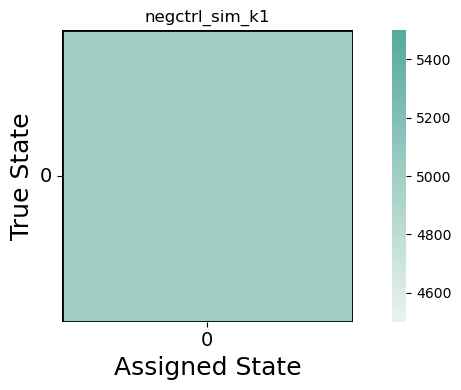

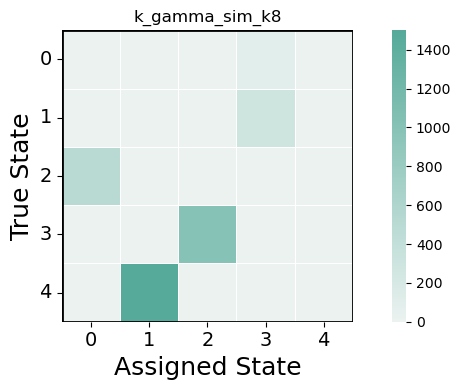

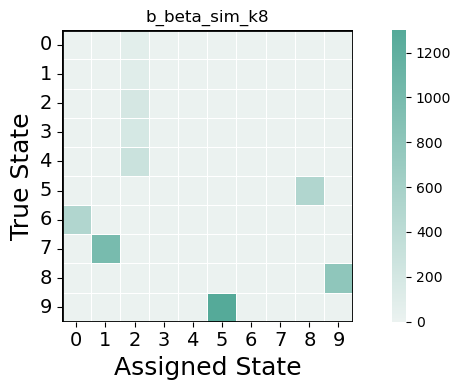

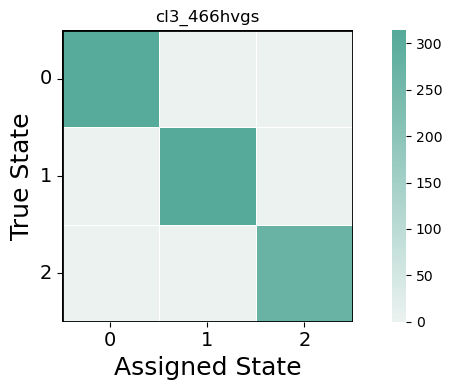

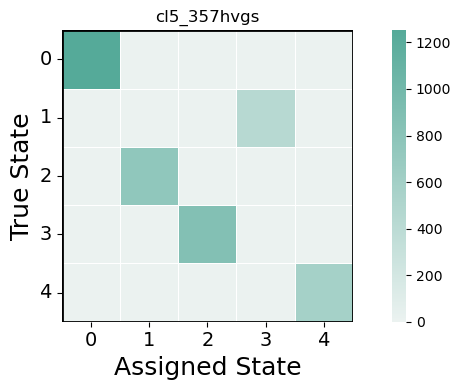

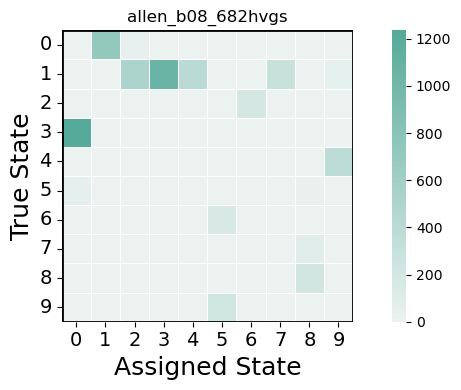

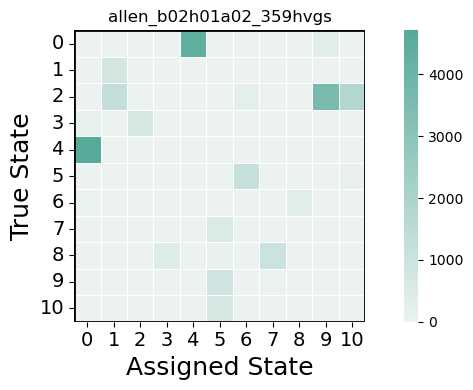

In [263]:
#Confusion matrices for each dataset\
for r,l in zip(sr,looms):
    cats = get_assigns(r)
    ds = lp.connect(l)
    true_labs = ds.ca['subclass_label']
    ds.close()
    fname = l[l.rfind('/')+1:l.rfind('.loom')]+'_conf_mat.pdf'
    plot_conf_mat(true_labs,cats,title=l[l.rfind('/')+1:l.rfind('.loom')],figsize=(8, 4),fname=fname)

    print(fname)

Annotations converted to:  {0: 0}
(2, 2)
negctrl_sim_k1_conf_mat.pdf
Annotations converted to:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


k_gamma_sim_k8_conf_mat.pdf
Annotations converted to:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
b_beta_sim_k8_conf_mat.pdf


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


Annotations converted to:  {'H1975': 0, 'H2228': 1, 'HCC827': 2}
processed_cl3_raw_conf_mat.pdf
Annotations converted to:  {'A549': 0, 'H1975': 1, 'H2228': 2, 'H838': 3, 'HCC827': 4}


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


processed_cl5_raw_conf_mat.pdf
Annotations converted to:  {'L2/3 IT': 0, 'L5 IT': 1, 'L5/6 NP': 2, 'L6 CT': 3, 'L6 IT': 4, 'L6b': 5, 'Lamp5': 6, 'Pvalb': 7, 'Sst': 8, 'Vip': 9}
processed_allen_A08_raw_conf_mat.pdf
Annotations converted to:  {'L2/3 IT': 0, 'L5 ET': 1, 'L5 IT': 2, 'L5/6 NP': 3, 'L6 CT': 4, 'L6 IT': 5, 'L6b': 6, 'Lamp5': 7, 'Pvalb': 8, 'Sst': 9, 'Vip': 10}


/home/tchari/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/matrixlib/defmatrix.py:69: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


processed_allen_B02H01A02_raw_conf_mat.pdf


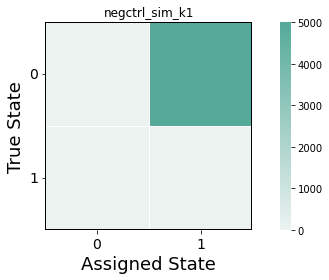

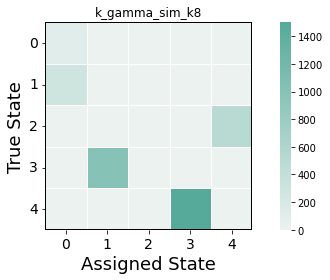

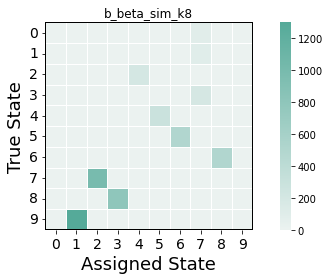

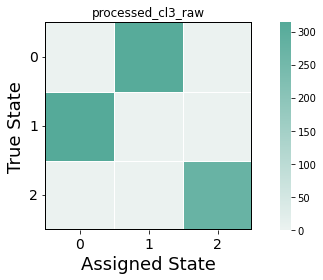

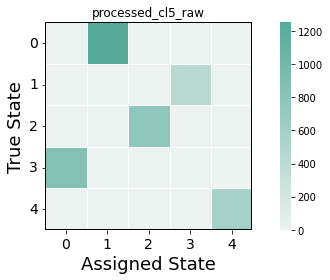

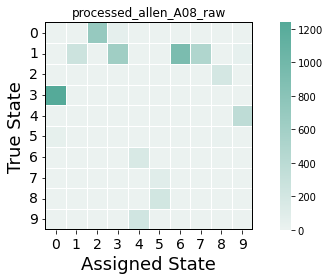

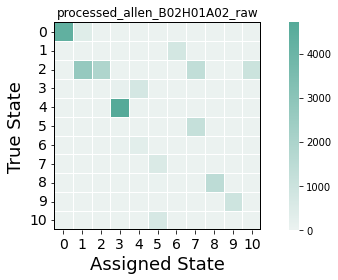

In [517]:
# #Confusion matrices for each dataset\
# for r,l in zip(sr,looms):
#     cats = get_assigns(r)
#     ds = lp.connect(l)
#     true_labs = ds.ca['subclass_label']
#     ds.close()
#     fname = l[l.rfind('/')+1:l.rfind('.loom')]+'_conf_mat.pdf'
#     plot_conf_mat(true_labs,cats,title=l[l.rfind('/')+1:l.rfind('.loom')],figsize=(8, 4),fname=fname)

#     print(fname)

In [518]:
#Compare (3,8) (4,8 in original)
#Compare (3,4) (4,3 in original)

negctrl_sim_k1_clus0_means_corr.pdf
k_gamma_sim_k8_clus0_means_corr.pdf
b_beta_sim_k8_clus0_means_corr.pdf
cl3_466hvgs_clus2_means_corr.pdf
cl5_357hvgs_clus4_means_corr.pdf
allen_b08_682hvgs_clus6_means_corr.pdf
allen_b02h01a02_359hvgs_clus0_means_corr.pdf


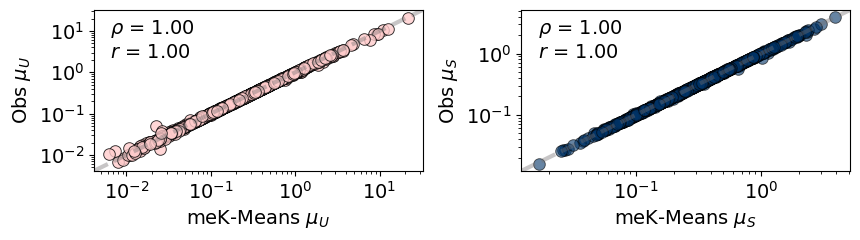

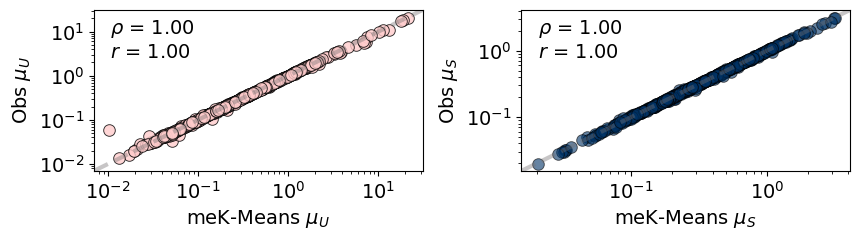

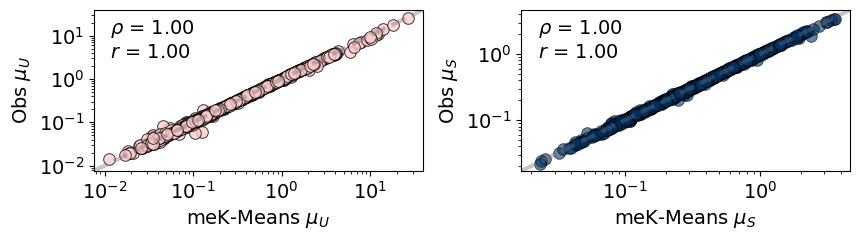

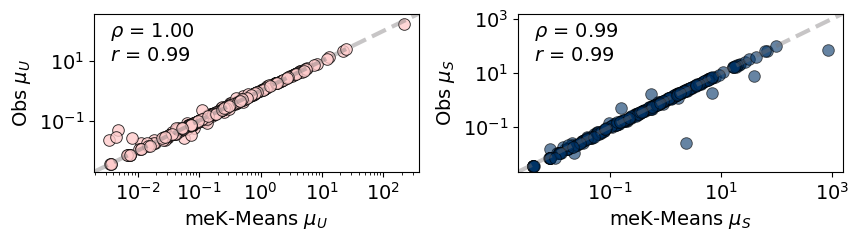

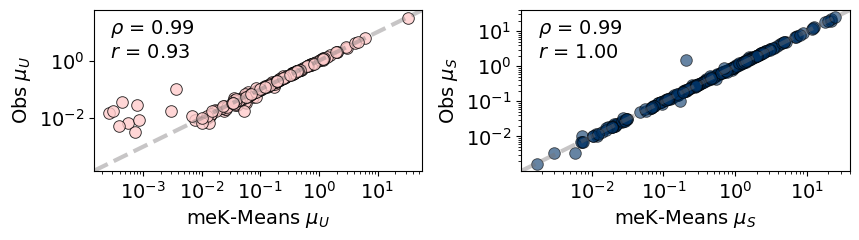

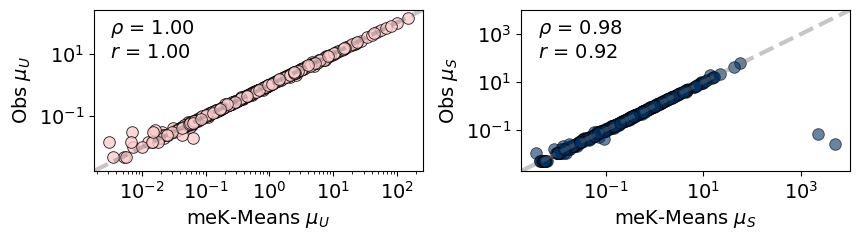

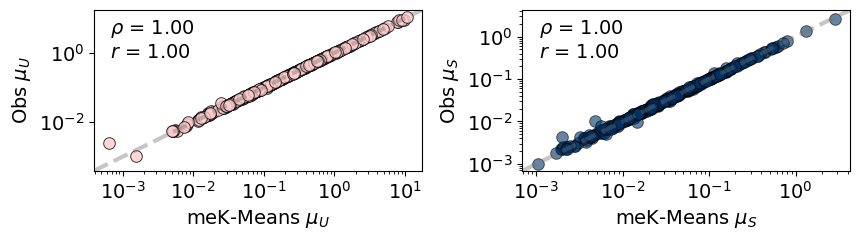

In [98]:
#Mean U,S correlations to parameters for one cluster per dataset
clus_list = [0,0,0,2,4,6,0]#[1,4,5,2,4,6,8]

for d,r,clus,l in zip(sd,sr,clus_list,looms):
    fname = l[l.rfind('/')+1:l.rfind('.loom')]+'_clus'+str(clus)+'_means_corr.pdf'
    plot_means(d,r,clus=clus,figsize=(8.7,2.5),fname=fname)
    print(fname)

In [249]:
#Plot param correlations for simulation datasets
out_path = './'
# all_params = np.load(out_path+'all_params.npy',allow_pickle=True) #Only for python <3.7
# all_marks= np.load(out_path+'all_marks.npy',allow_pickle=True)

In [219]:
len(all_params)

2

In [251]:
import pickle

In [252]:
with open(out_path+'all_params.pkl','rb') as f:
    all_params = pickle.load(f)
    print(all_params[0].shape)

with open(out_path+'all_marks.pkl','rb') as f:
    all_marks = pickle.load(f)
    print(all_marks[0].shape)

(10, 1100, 6)
(1000,)


ksim10_trueparams_corr.pdf
ksim5_trueparams_corr.pdf


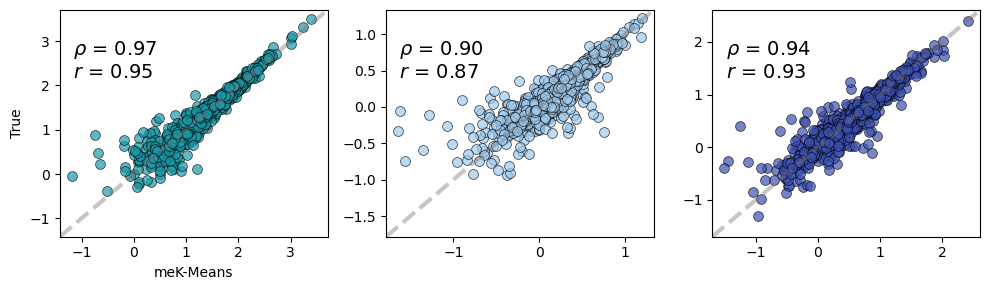

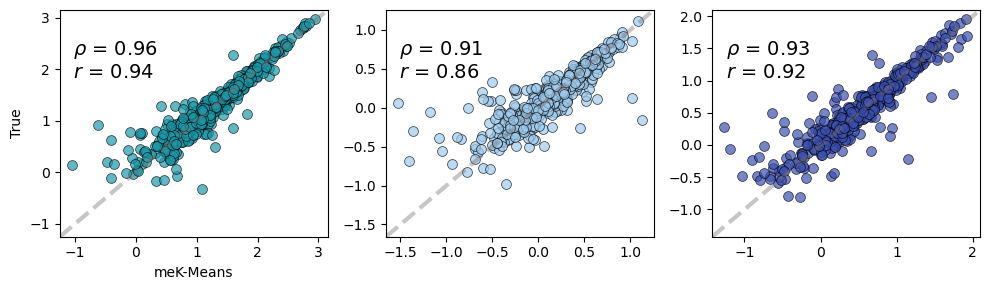

In [224]:
sims_sr = [sr[2],sr[1]]
clus_pairs =  [[6,0],[2,0]]#[[4,5],[2,4]]
names_tosave = ['ksim10','ksim5']
for r in range(len(sims_sr)):  #Saved in reverese direction in all_params
    plot_true_params(all_params[r],sims_sr[r],
                     true_clus=clus_pairs[r][0],fit_clus=clus_pairs[r][1],
                     figsize=(10,3),fname=names_tosave[r]+'_trueparams_corr.pdf')
    print(names_tosave[r]+'_trueparams_corr.pdf')

In [239]:
#phys_lb = [-3.0, -3, -3 ]  for simulation data

In [253]:
#negctrl

out_path = './'
all_params_neg = np.load(out_path+'negctrl_params.npy',allow_pickle=True)
#all_marks_neg = np.load(out_path+'all_marks.npy',allow_pickle=True)


negctrl_trueparams_corr.pdf


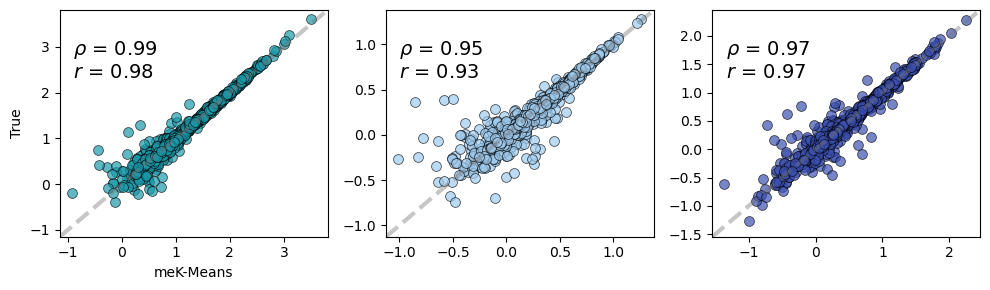

In [226]:
sims_sr = [sr[0]]
clus_pairs = [[0,0]]
names_tosave = ['negctrl']
for r in range(len(sims_sr)):  #Saved in reverese direction in all_params
    plot_true_params([all_params_neg][r],sims_sr[r],
                     true_clus=clus_pairs[r][0],fit_clus=clus_pairs[r][1],
                     figsize=(10,3),fname=names_tosave[r]+'_trueparams_corr.pdf')
    print(names_tosave[r]+'_trueparams_corr.pdf')

**ADD 3D PLOTS FOR SIMULATIONS**

ksim10_3d_params.pdf
          b      beta     gamma         state
0  1.662903 -0.194213  0.196432  Marked State
1  0.821663 -0.732937  0.162057  Marked State
2  0.777225 -0.521212  0.156987  Marked State
3  1.426331 -0.381566  0.107965  Marked State
4  1.793277  0.203995  0.436960  Marked State
ksim10_joint_params.pdf
ksim5_3d_params.pdf
          b      beta     gamma         state
0  1.106730 -0.376186  0.296310  Marked State
1  2.050262 -0.148931  1.031722  Marked State
2  1.850947  0.017940  1.488579  Marked State
3  1.466224 -0.044859  0.139870  Marked State
4  2.401189  0.612417  1.453249  Marked State
ksim5_joint_params.pdf


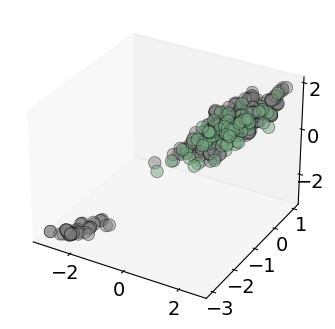

<Figure size 640x480 with 0 Axes>

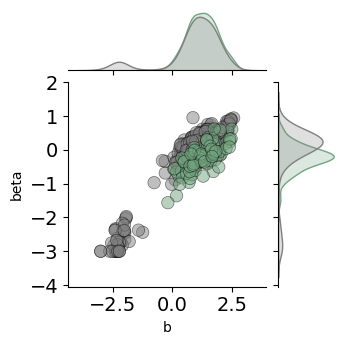

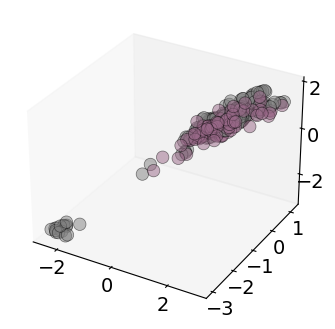

<Figure size 640x480 with 0 Axes>

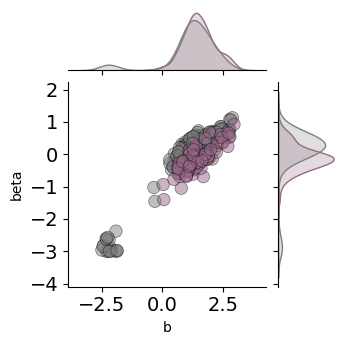

In [231]:
colors = ['#73a580','#996888']
sims_sr = [sr[2],sr[1]]
clus_pairs =  [[6,0],[2,0]]#[[4,5],[2,4]]
names_tosave = ['ksim10','ksim5']

for r in range(len(sims_sr)):
    plot_3d_markers(sims_sr[r],all_marks[r],
                    true_clus=clus_pairs[r][0],fit_clus=clus_pairs[r][1],
                    mark_color = colors[r],figsize=(4,4),fname=names_tosave[r]+'_3d_params.pdf')
    print(names_tosave[r]+'_3d_params.pdf')
    
    plot_joint_markers(sims_sr[r],all_marks[r],
                    true_clus=clus_pairs[r][0],fit_clus=clus_pairs[r][1],
                    mark_color = colors[r],figsize=(1,1),fname=names_tosave[r]+'_joint_params.pdf')
    print(names_tosave[r]+'_joint_params.pdf')
    
    

### **DE-$\theta$ Plots for Benchmarks**

In [36]:
def make_fcs(sr,sd,clus1=0,clus2=1,gf_rej=False,thrpars=2,thrmean=1,outlier_de=True,nuc=False):
    '''
    Utilize different metrics to find fold-changes (FCs) between cluster parameters

    sr: list of SearchResults objects from meK-Means runs
    sd: SearchData object that corresponds to full, input data
    clus1: cluster 1 (to compare FCS of cluster 1/cluster 2 )
    clus2: cluster 2 (to compare FCS of cluster 1/cluster 2 )
    gf_rej: whether to use boolean list of rejected genes from both clusters
    thrpars: FC threshold value (to call DE-theta genes)
    thrmean: Mean S expression threshold value, for genes to consider
    outlier_de: Use iterative outlier calling procedure to assign DE-theta genes (see Monod https://github.com/pachterlab/monod_examples/blob/main/Monod_demo.ipynb)
    nuc: is this nuclear RNA data
    '''

    all_filt_fcs = pd.DataFrame()
    fcs,types,which_pair,highFC,spliceFC,g_names,out_de = ([] for i in range(7))
    
    ind1 = [i for i in range(len(sr)) if clus1 == sr[i].assigns][0]
    ind2 = [i for i in range(len(sr)) if clus2 == sr[i].assigns][0]

    sr1 = sr[ind1]
    sr2 = sr[ind2]
    fc_par = (sr1.param_estimates-sr2.param_estimates)/np.log10(2)  #Get FCs between cluster params
    print('fc_par.shape: ',fc_par.shape)
    if nuc:
        fc_s_par = np.log2(sd.layers[0][:,sr1.filt].mean(1)/sd.layers[0][:,sr2.filt].mean(1))
    else:
        fc_s_par = np.log2(sd.layers[1][:,sr1.filt].mean(1)/sd.layers[1][:,sr2.filt].mean(1)) #Get spliced FCs
        
    print('fc_s_par.shape: ',fc_s_par.shape)

    if outlier_de:
        dr_analysis = monod.analysis.diffexp_pars(sr1,sr2,viz=True,modeltype='id',use_sigma=True)
        par_bool_de = dr_analysis[1].T

    parnames = ('b','beta','gamma')


  #-----is parameter FC significant -----
    if gf_rej is False:
        gf_rej = [True]*sd.n_genes
    else:
        gf_rej = (~sr1.rejected_genes) & (~sr2.rejected_genes)
        
    for n in range(len(parnames)):
        #Boolean for if large param FC and not rejected gene (with minimum expression)
        if nuc:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[0][:,sr1.filt].mean(1)>thrmean) | (sd.layers[0][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej
        else:
            gf_highnoise = (np.abs(fc_par[0,:,n])>thrpars)  \
                & ((sd.layers[1][:,sr1.filt].mean(1)>thrmean) | (sd.layers[1][:,sr2.filt].mean(1)>thrmean)) \
                & gf_rej

        #Boolean for FC (above) but no FC detected at S-level
        gf_highnoise_meanS = gf_highnoise & (np.abs(fc_s_par)<1) & gf_rej

        #Boolean for FC (above)
        gf_onlyhigh = gf_highnoise & gf_rej

        #For dataframe
        fcs += list(fc_par[0,gf_rej,n])
        g_names += list(sr1.gene_names[gf_rej])
        which_pair += [[sr1.assigns,sr2.assigns]]*np.sum(gf_rej)
        highFC += list(gf_onlyhigh[gf_rej])
        spliceFC += list(gf_highnoise_meanS[gf_rej])
        types += [parnames[n]]*np.sum(gf_rej)
        if outlier_de:
            out_de += list(par_bool_de[gf_rej,n])

    if outlier_de:
        all_filt_fcs['deTheta_outlier'] = out_de

    all_filt_fcs['log2FC'] = fcs
    all_filt_fcs['gene'] = g_names
    all_filt_fcs['cluster_pair'] = which_pair
    all_filt_fcs['deTheta_FC'] = highFC
    all_filt_fcs['deTheta_noDeMuS'] = spliceFC
    all_filt_fcs['param'] = types

    return all_filt_fcs


In [37]:
#Get params for each gene, which cluster it marks, and whether it's DE in any param
def get_gene_DE(all_filt_fcs):
    bs = all_filt_fcs[all_filt_fcs.param.isin(['b'])].log2FC
    betas = all_filt_fcs[all_filt_fcs.param.isin(['beta'])].log2FC
    gammas = all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].log2FC
    highFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_FC)
    noSpliceFCs = np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].deTheta_noDeMuS) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].deTheta_noDeMuS)

    names = all_filt_fcs[all_filt_fcs.param.isin(['b'])].gene

    dom = []
    for i in range(len(noSpliceFCs)):
        fc_b = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].log2FC)[0]
        fc_beta = list(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].log2FC)[0]
        fc_gamma = list(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].log2FC)[0]

        sig_b = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].deTheta_noDeMuS))[0]
        sig_beta = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['beta'])].iloc[[i]].deTheta_noDeMuS))[0]

        sig_gamma = list(np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_FC) | np.array(all_filt_fcs[all_filt_fcs.param.isin(['gamma'])].iloc[[i]].deTheta_noDeMuS))[0]


        pairs = list(all_filt_fcs[all_filt_fcs.param.isin(['b'])].iloc[[i]].cluster_pair)[0]

# ----- Cell type 'marker' means increase in burst freq,burst,or splicing, or decrease in deg (increased 'stability') ----

        #Increase in burst freq (not outweighted by burst size)
        if (-1*fc_beta > 0 and sig_beta and -1*fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[0]]
            elif (fc_b > 0 and sig_b):
                dom += [pairs[0]]
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif (fc_beta > 0 and sig_beta and fc_gamma > 0 and sig_gamma) :
            if (np.abs(fc_b) < np.abs(fc_beta)):
                dom += [pairs[1]]
            elif (fc_b > 0 and sig_b):
                dom += ['None'] #don't know
            elif (fc_b < 0 and sig_b):
                dom += [pairs[1]]
            else:
                dom += ['None']
        elif sig_b:
            if np.abs(fc_b) > np.abs(fc_beta) and np.abs(fc_b) > np.abs(fc_gamma):
                if fc_b > 0:
                    dom += [pairs[0]]
                else:
                    dom += [pairs[1]]            
            elif np.abs(fc_b) < np.abs(fc_beta):
                if fc_beta > 0:
                    dom += [pairs[0]]
                elif fc_beta < 0:
                    dom += [pairs[1]]
            elif np.abs(fc_b) < np.abs(fc_gamma):
                if fc_gamma < 0:
                    dom += [pairs[0]]
                elif fc_gamma > 0:
                    dom += [pairs[1]]
            else:
                dom += ['None']       
        elif (fc_beta > 0 and sig_beta):
            dom += [pairs[0]]
        elif (fc_gamma > 0 and sig_gamma): #individual FCs
            dom += [pairs[1]]
        elif  (fc_beta < 0 and sig_beta):
            dom += [pairs[1]]
        elif (fc_gamma < 0 and sig_gamma):
            dom += [pairs[0]]
        else:
            dom += ['None']


    return bs,-1*betas,-1*gammas,dom,highFCs,noSpliceFCs,names #-1 for plotting purposes

In [38]:
#Plot FCs of parameters between two clusters

def plot_de(outs,names_plot,mark_plot,xpos,ypos,arrow,assign_colors,figsize=(10,4),betag=False,xlims=[-10,10],fname=None):
    fig,ax = plt.subplots(1,2,figsize=figsize)

    name_inds = [list(outs[6]).index(i) for i in names_plot]

    labs = np.array(outs[3])
    g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[1][labs=='None']),
                      hue=list(pd.Categorical(outs[3])[labs=='None']),
                      palette=assign_colors,ax=ax[0],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                    y=list(outs[1][(labs!='None') &  (outs[5]==False)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None') &  (outs[5]==False)]),
                      palette=assign_colors,ax=ax[0],marker='o',alpha=0.6,s=100,edgecolor='black')

    sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                    y=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                    hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                      palette=assign_colors,ax=ax[0],marker='X',alpha=0.8,s=120,edgecolor='black')

    #Annotate genes
    for n in range(len(names_plot)):
        x=list(outs[0])[name_inds[n]]
        y=list(outs[1])[name_inds[n]]
        h=[pd.Categorical(outs[3])[name_inds[n]]]
        if_x=list(outs[5])[name_inds[n]]
        
        if if_x:
            shape = 'X'
        else:
            shape = 'o'
            
        if arrow[n]:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y), fontsize=14,
                           xytext=(x+xpos[n],y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                       arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                         arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",lw=0.4))
        else:
            #Replot, so annotated points show up on top
            sns.scatterplot(x=x,
                    y=y,
                    hue=h,
                      palette=assign_colors,ax=ax[0],marker=shape,alpha=0.8,s=120,edgecolor='black',
                           legend=False)
            
            ax[0].annotate(names_plot[n], (x, y),fontsize=14,
                           xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")

    sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

    xl =np.asarray([xlims[0],xlims[1]])
    xlx = [xl[0],xl[1]]
    xly = [xl[0],xl[1]]
    ax[0].set_xlim(xlx)
    ax[0].set_ylim(xly)

    ax[0].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

    ax[0].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
    ax[0].set_ylabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
    
    ax[0].tick_params(axis='both', which='major', labelsize=14,)




    if betag == False:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[0][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[0][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[0])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=100,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
            
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")


        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,-xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$\log_{2}$FC $b$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
    else:
        labs = np.array(outs[3])
        g=sns.scatterplot(x=list(outs[1][labs =='None']),y=list(outs[2][labs=='None']),
                          hue=list(pd.Categorical(outs[3])[labs=='None']),
                          palette=assign_colors,ax=ax[1],style=list(outs[5][labs=='None']),alpha=0.1,s=100,edgecolor='black')

        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==False)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==False)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==False)]),
                          palette=assign_colors,ax=ax[1],marker='o',alpha=0.6
                        ,s=100,edgecolor='black')

        
        sns.scatterplot(x=list(outs[1][(labs!='None')  &  (outs[5]==True)]),
                        y=list(outs[2][(labs!='None')  &  (outs[5]==True)]),
                        hue=list(pd.Categorical(outs[3])[(labs!='None')  &  (outs[5]==True)]),
                          palette=assign_colors,ax=ax[1],marker='X',
                        alpha=0.8,s=120,edgecolor='black')
        #Annotate genes
        for n in range(len(names_plot)):
            x=list(outs[1])[name_inds[n]]
            y=list(outs[2])[name_inds[n]]
            h=[pd.Categorical(outs[3])[name_inds[n]]]
            if_x=list(outs[5])[name_inds[n]]

            if if_x:
                shape = 'X'
            else:
                shape = 'o'

                
            if arrow[n]:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),weight="bold", color=assign_colors[mark_plot[n]],
                           arrowprops = dict(facecolor=assign_colors[mark_plot[n]],  
                                             arrowstyle="-|>",connectionstyle="angle3,angleA=0,angleB=-90",
                                             lw=0.4,))
            else:
                #Replot, so annotated points show up on top
                sns.scatterplot(x=x,
                        y=y,
                        hue=h,
                          palette=assign_colors,ax=ax[1],marker=shape,alpha=0.8,s=120,edgecolor='black',
                               legend=False)
                
                ax[1].annotate(names_plot[n], (x, y), fontsize=14,
                               xytext=(x+xpos[n], y+ypos[n]),color=assign_colors[mark_plot[n]],weight="bold")



        sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))

        xl =np.asarray([xlims[0],xlims[1]])
        xlx = [xl[0],xl[1]]
        xly = [xl[0],xl[1]]
        ax[1].set_xlim(xlx)
        ax[1].set_ylim(xly)

        ax[1].plot(xl,xl,'--',linewidth=2.5,c='crimson',alpha=0.3)

        ax[1].set_xlabel(r'$-\log_{2}$FC $\beta$ ',fontsize=14)
        ax[1].set_ylabel(r'$-\log_{2}$FC $\gamma$ ',fontsize=14)
        
        ax[1].tick_params(axis='both', which='major', labelsize=14,)
        

    plt.tight_layout()
    if fname is None:
        plt.show()
    else:
        plt.savefig(fname)



Looking at allen nuc Data specifically

Need to:
1. Reject genes with poor fits
2. Plot DE genes between Glut./Glut. or Glut./GABA population

In [100]:
#For allen B02H01A02 nuc data
#Compare (3,8) (4,8 in original)
#Compare (3,4) (4,3 in original)
#Annotations converted to:  {'L2/3 IT': 0, 'L5 ET': 1, 'L5 IT': 2, 'L5/6 NP': 3, 
# 'L6 CT': 4, 'L6 IT': 5, 'L6b': 6, 'Lamp5': 7, 'Pvalb': 8, 'Sst': 9, 'Vip': 10}
    
    
    
chosen = 6
sr_ofinterest = sr[chosen] 
sd_ofinterest = sd[chosen]


In [118]:
#Set colors for 10 clusters
pal =['#E48F15','#58AD8B','#B33254','#403A5C','#FFEAB0',
        '#7458A6','#F8DBD8','#5f7a56','#F2BF94','#7793c2','#CCCCFF']
assign_colors = dict(zip(range(len(pal)),pal))
assign_colors['None'] = 'lightgrey'

In [41]:
import re

In [102]:
#Run gene rejection statistics
result_strings_ofinterest = result_strings[chosen]
dash_inds = [m.start() for m in re.finditer('/', result_strings_ofinterest[0])]
dir_string = result_strings_ofinterest[0][:dash_inds[3]]

for r in sr_ofinterest:

    fig1,ax1 = plt.subplots(1,1)
    r.find_sampling_optimum() #There is only one set of sampling parameters

    fig1,ax1 = plt.subplots(1,1)
    r.plot_KL(ax1)
    r.plot_gene_distributions(sd_ofinterest,marg='joint')

    _=r.chisquare_testing(sd_ofinterest,threshold=1e-3) #Chi-sq rejection testing
    r.chisq_best_param_correction(sd_ofinterest,Ntries=4,viz=False,threshold=1e-3) 

    r.compute_sigma(sd_ofinterest,num_cores=30) #Sigma, std error calcs
    r.plot_param_L_dep(plot_errorbars=False,plot_fit=True) #Check if burst length-dep exists
    r.plot_param_marg()

    monod.analysis.make_batch_analysis_dir([r],dir_string)
    r.update_on_disk()

In [103]:
result_strings_upd = []
for i in result_strings_ofinterest: 
    result_strings_upd += [glob.glob(i[:-4]+'_upd.res')]
    
sr_allen = [] #SearchResults for each dataset
for strings in result_strings_upd:
    sr_allen += [monod.analysis.load_search_results(i) for i in strings]

len(sr_allen)

11

In [124]:
#L5/6 NP, L6 CT, Pvalb markers
#L6 IT, L6 CT, Pvalb markers
#NP markers from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6456269/pdf/nihms-1001532.pdf
np_marks =  ['Slc17a7','Fezf2','Rorb','Lypd1','Tmem163','Wls','Ctgf']

#intratelencephalically projecting 
#
it_marks = ['Slc17a7','Slc30a3','Sulf1','Calb1','Lamp5','Rorb','Deptor']
ct_marks = ['Slc17a7','Fezf2','Sulf1','Foxp2','Ntsr1','Elavl2', 'Rbfox1']
pvalb_marks = ['Slc32a1','Pvalb','Lhx6','Gad1']

Get param-FCs between clusters of interest

fc_par.shape:  (1, 358, 3)
fc_s_par.shape:  (358,)


/tmp/ipykernel_3036041/160940191.py:27: RuntimeWarning: divide by zero encountered in log2
  fc_s_par = np.log2(sd.layers[0][:,sr1.filt].mean(1)/sd.layers[0][:,sr2.filt].mean(1))


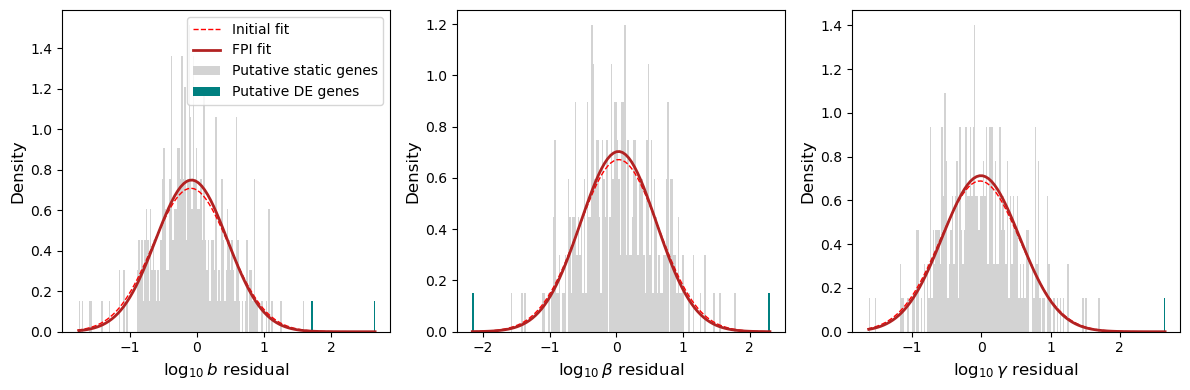

In [125]:
#Compare (3,8) (4,8 in original) -->old
#Compare (3,4) (4,3 in original)


#Compare 0 vs 7 (L6 CT vs Pvalb)

all_filt_fcs = make_fcs(sr_allen,sd_ofinterest,clus1=0,clus2=7,
                gf_rej=True,thrpars=2,thrmean=0.1,outlier_de=True,nuc=True)

In [126]:
all_filt_fcs.head()

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
0,False,-3.069664,Nrp2,"[0, 7]",False,False,b
1,False,-2.340604,Cdh7,"[0, 7]",True,False,b
2,False,0.321085,Tmem163,"[0, 7]",False,False,b
3,False,-0.855463,Nek7,"[0, 7]",False,False,b
4,False,0.568471,Cnih3,"[0, 7]",False,False,b


In [127]:
all_filt_fcs[all_filt_fcs['gene'].isin(pvalb_marks+ct_marks)]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
84,False,-2.183390,Pvalb,"[0, 7]",True,False,b
156,False,0.511547,Slc32a1,"[0, 7]",False,False,b
161,False,-3.647886,Gad1,"[0, 7]",True,False,b
235,False,2.223241,Foxp2,"[0, 7]",True,False,b
384,False,3.717551,Pvalb,"[0, 7]",True,False,beta
456,True,7.990259,Slc32a1,"[0, 7]",True,False,beta
461,False,3.919577,Gad1,"[0, 7]",True,False,beta
535,False,-3.604844,Foxp2,"[0, 7]",True,False,beta
684,False,3.149655,Pvalb,"[0, 7]",True,False,gamma
756,False,4.573900,Slc32a1,"[0, 7]",True,False,gamma


In [128]:
all_filt_fcs[all_filt_fcs['deTheta_noDeMuS'].isin([True])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
280,False,2.313735,Dscaml1,"[0, 7]",True,True,b
288,False,2.732369,Cpne4,"[0, 7]",True,True,b
329,False,-2.249554,Grm1,"[0, 7]",True,True,beta
366,False,-2.279383,Elmo1,"[0, 7]",True,True,beta
447,False,-2.142259,Cdh4,"[0, 7]",True,True,beta
588,False,2.878684,Cpne4,"[0, 7]",True,True,beta
629,False,-2.159755,Grm1,"[0, 7]",True,True,gamma
666,False,-2.497190,Elmo1,"[0, 7]",True,True,gamma
747,False,-2.754835,Cdh4,"[0, 7]",True,True,gamma
873,False,2.432891,Cdh13,"[0, 7]",True,True,gamma


In [129]:
out_marks = get_gene_DE(all_filt_fcs)

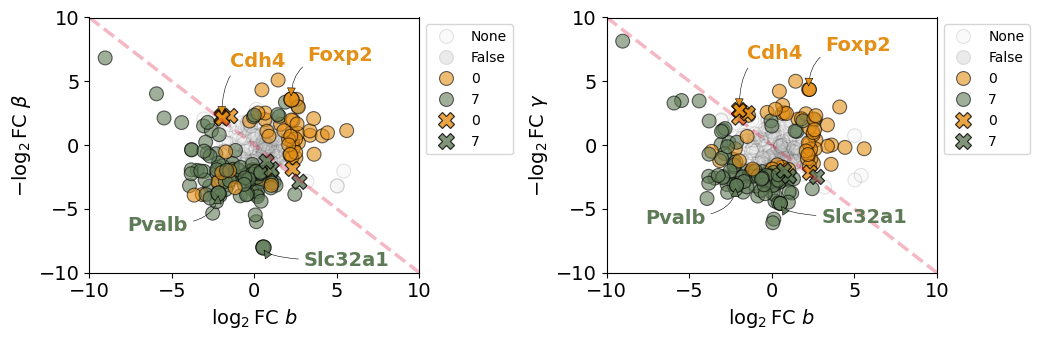

In [136]:
names_plot = ['Pvalb','Slc32a1','Cdh4','Foxp2']
mark_plot = [7,7,0,0]
xpos = [-5.5,2.5,0.5,1]
ypos = [-3,-1.5,4,3]
arrow = [True,True,True,True]

plot_de(out_marks,names_plot ,mark_plot,xpos,ypos,arrow,
        assign_colors,figsize=(10.5,3.5),fname='allen_nuc_CTvsPvalb.pdf')

In [111]:
#Differential use of cadherins in diff brain regions
#https://anatomypubs.onlinelibrary.wiley.com/doi/full/10.1002/dvdy.22686 (Cdh6)

#Cdh4 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2080860/

Do Glut. vs Glut.

fc_par.shape:  (1, 358, 3)
fc_s_par.shape:  (358,)


/tmp/ipykernel_3036041/160940191.py:27: RuntimeWarning: divide by zero encountered in log2
  fc_s_par = np.log2(sd.layers[0][:,sr1.filt].mean(1)/sd.layers[0][:,sr2.filt].mean(1))
/home/tchari/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


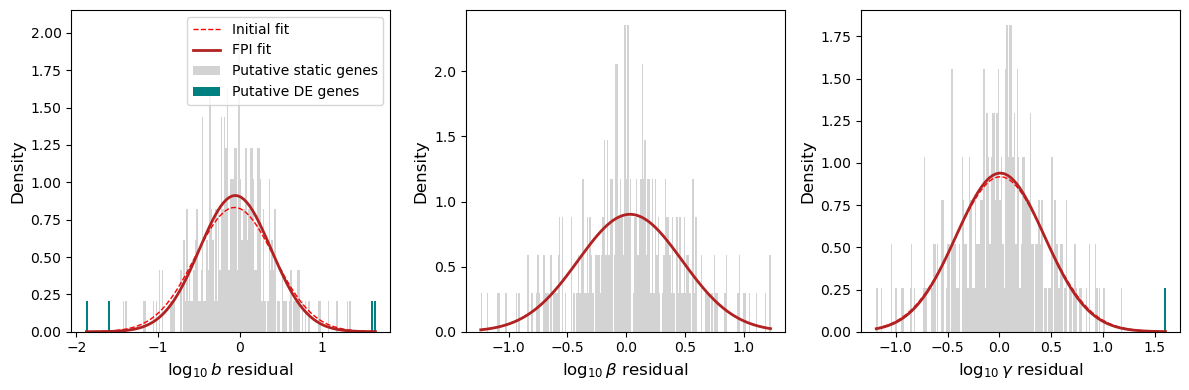

In [141]:
#Compare 0 vs 2 (L6 CT vs NP)  

all_filt_fcs = make_fcs(sr_allen,sd_ofinterest,clus1=0,clus2=2,
                gf_rej=True,thrpars=1.5,thrmean=0.1,outlier_de=True,nuc=True) #Set thresh lower between two Gluts (?)

out_marks = get_gene_DE(all_filt_fcs)

In [142]:
all_filt_fcs[all_filt_fcs['gene'].isin(np_marks+ct_marks)]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
2,False,-4.348964,Tmem163,"[0, 2]",True,False,b
128,False,-0.403811,Rorb,"[0, 2]",False,False,b
172,False,-1.876381,Wls,"[0, 2]",True,False,b
215,False,1.828628,Foxp2,"[0, 2]",True,False,b
278,False,0.832123,Tmem163,"[0, 2]",False,False,beta
404,False,0.048077,Rorb,"[0, 2]",False,False,beta
448,False,2.177470,Wls,"[0, 2]",True,False,beta
491,False,-0.829322,Foxp2,"[0, 2]",False,False,beta
554,False,1.077980,Tmem163,"[0, 2]",False,False,gamma
680,False,0.382353,Rorb,"[0, 2]",False,False,gamma


In [143]:
all_filt_fcs[all_filt_fcs.deTheta_noDeMuS.isin([True])]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
45,False,-1.864644,Stxbp6,"[0, 2]",True,True,b
127,False,2.129945,Trpm3,"[0, 2]",True,True,b
166,False,1.567229,Pigk,"[0, 2]",True,True,b
224,False,1.772225,Gm26673,"[0, 2]",True,True,b
383,False,-1.631676,Rps6ka2,"[0, 2]",True,True,beta
439,False,-2.003904,Fstl5,"[0, 2]",True,True,beta
576,False,2.210594,Epb41l2,"[0, 2]",True,True,gamma
597,False,-2.300014,Stxbp6,"[0, 2]",True,True,gamma
659,False,-2.411775,Rps6ka2,"[0, 2]",True,True,gamma
663,False,-1.641754,Plekhh2,"[0, 2]",True,True,gamma


In [144]:
all_filt_fcs[all_filt_fcs.deTheta_noDeMuS.isin([False]) & all_filt_fcs.deTheta_FC.isin([True]) & (all_filt_fcs.log2FC < 0)]

,deTheta_outlier,log2FC,gene,cluster_pair,deTheta_FC,deTheta_noDeMuS,param
0,False,-3.981343,Nrp2,"[0, 2]",True,False,b
2,False,-4.348964,Tmem163,"[0, 2]",True,False,b
6,False,-1.730065,Dner,"[0, 2]",True,False,b
17,True,-5.509432,Lama4,"[0, 2]",True,False,b
32,False,-3.575895,Rmst,"[0, 2]",True,False,b
...,...,...,...,...,...,...,...
766,False,-1.611491,Cadps2,"[0, 2]",True,False,gamma
774,False,-2.081380,Ptprz1,"[0, 2]",True,False,gamma
796,False,-1.711863,Plekha2,"[0, 2]",True,False,gamma
813,False,-2.152990,Ephb1,"[0, 2]",True,False,gamma


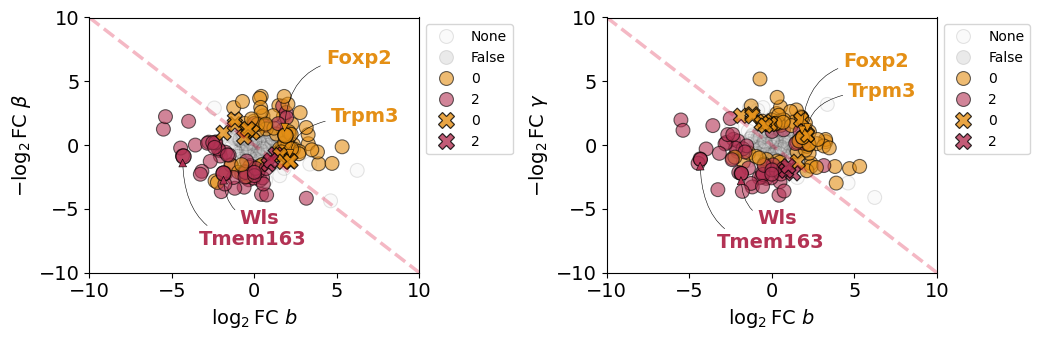

In [150]:
names_plot = ['Foxp2','Trpm3','Tmem163','Wls'] #['Pvalb','Slc32a1','Foxp2','Cdh6']
mark_plot = [0,0,2,2]
xpos = [2.5,2.5,1,1]
ypos = [5.5,3,-7,-4]
arrow = [True,True,True,True]

plot_de(out_marks,names_plot,mark_plot,xpos,ypos,arrow,
        assign_colors,figsize=(10.5,3.5),fname='allen_nuc_CTvsNP.pdf')